# 1) Data Understanding

In [135]:
#! pip install pandas
#! pip install numpy
#! pip install matplotlib
#! pip install seaborn

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [137]:
data = pd.read_csv('data')

In [138]:
data.head()

code_module code_presentation  id_student  date_registration  \
0         AAA             2013J       11391             -159.0   
1         AAA             2013J       11391             -159.0   
2         AAA             2013J       11391             -159.0   
3         AAA             2013J       11391             -159.0   
4         AAA             2013J       11391             -159.0   

   date_unregistration gender               region highest_education imd_band  \
0                  NaN      M  East Anglian Region  HE Qualification  90-100%   
1                  NaN      M  East Anglian Region  HE Qualification  90-100%   
2                  NaN      M  East Anglian Region  HE Qualification  90-100%   
3                  NaN      M  East Anglian Region  HE Qualification  90-100%   
4                  NaN      M  East Anglian Region  HE Qualification  90-100%   

  age_band  ...  final_result  module_presentation_length total_clicks  \
0     55<=  ...          Pass                         268          934   
1     55<=  ...          Pass                         268          934   
2     55<=  ...          Pass                         268          934   
3     55<=  ...          Pass                         268          934   
4     55<=  ...          Pass                         268          934   

  id_assessment  assessment_type   date  weight date_submitted  is_banked  \
0          1752              TMA   19.0    10.0             18          0   
1          1753              TMA   54.0    20.0             53          0   
2          1754              TMA  117.0    20.0            115          0   
3          1755              TMA  166.0    20.0            164          0   
4          1756              TMA  215.0    30.0            212          0   

   score  
0   78.0  
1   85.0  
2   80.0  
3   85.0  
4   82.0  

[5 rows x 23 columns]

In [139]:
data.shape

(173744, 23)

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173744 entries, 0 to 173743
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   code_module                 173744 non-null  object 
 1   code_presentation           173744 non-null  object 
 2   id_student                  173744 non-null  int64  
 3   date_registration           173737 non-null  float64
 4   date_unregistration         12998 non-null   float64
 5   gender                      173744 non-null  object 
 6   region                      173744 non-null  object 
 7   highest_education           173744 non-null  object 
 8   imd_band                    166048 non-null  object 
 9   age_band                    173744 non-null  object 
 10  num_of_prev_attempts        173744 non-null  int64  
 11  studied_credits             173744 non-null  int64  
 12  disability                  173744 non-null  object 
 13  final_result  

## 1.1) Handling Missing Values

In [141]:
data.isnull().any()

code_module                   False
code_presentation             False
id_student                    False
date_registration              True
date_unregistration            True
gender                        False
region                        False
highest_education             False
imd_band                       True
age_band                      False
num_of_prev_attempts          False
studied_credits               False
disability                    False
final_result                  False
module_presentation_length    False
total_clicks                  False
id_assessment                 False
assessment_type               False
date                           True
weight                        False
date_submitted                False
is_banked                     False
score                          True
dtype: bool

In [142]:
missing = data.isna().sum().sort_values(ascending=False)
print(missing[missing > 0])

date_unregistration    160746
imd_band                 7696
date                     2864
score                     172
date_registration           7
dtype: int64


In [143]:
per_missing = data.isnull().sum() * 100/len(data)
print(per_missing)

code_module                    0.000000
code_presentation              0.000000
id_student                     0.000000
date_registration              0.004029
date_unregistration           92.518878
gender                         0.000000
region                         0.000000
highest_education              0.000000
imd_band                       4.429505
age_band                       0.000000
num_of_prev_attempts           0.000000
studied_credits                0.000000
disability                     0.000000
final_result                   0.000000
module_presentation_length     0.000000
total_clicks                   0.000000
id_assessment                  0.000000
assessment_type                0.000000
date                           1.648402
weight                         0.000000
date_submitted                 0.000000
is_banked                      0.000000
score                          0.098996
dtype: float64


#### Date Registration
Data la bassissima quantità di record che non posseggono una registration date, questa viene sostituita come la media della colonna rispetto a code_presentation.

In [144]:
data['date_registration'] = data.groupby('code_presentation')['date_registration'].transform(lambda x: x.fillna(x.mean()))

#### Date Unregistration
La percentuale di valori NaN così alta è dovuta al fatto che gli studenti che hanno completato il corso non hanno la data di unregistration, mentre gli altri hanno withdrawl. Questa informazione è contenuta in altre due colonne, final_result e score, dunque droppiamo la colonna.

In [145]:
data = data.drop(columns=["date_unregistration"])

#### IMD Band
La IMD Band è un indicatore utilizzato in Gran Bretagna per identificare lo stato sociale di una zona geografica. I valori NaN sono sostituiti con la media per regione. 

In [146]:
regions = data[data['imd_band'].isnull()]['region'].unique()

for region in regions:
  mode_imd_band = data[data['region'] == region]['imd_band'].mode()[0]
  data.loc[(data['imd_band'].isnull()) & (data['region'] == region), 'imd_band'] = mode_imd_band

#### Date
I valori mancanti in questo campo sono dovuti al fatto che l'assessment è un esame, che si tiene tipicamente nell'ultima settimana del corso. Per riempire i valori NaN in questo campo utilizziamo dunque l'ultimo giorno del corso. 

In [147]:
data['date'] = data['date'].fillna(data['module_presentation_length'])

#### Score
Tutti i valori mancanti nella colonna del voto corrispondono a tutor marked assignement e possono dunque essere interpretati come mancata consegna, a cui si assegna un voto uguale a 0.

In [148]:
nan_scores = data[data['score'].isna()]
nan_scores['assessment_type'].value_counts()

assessment_type
TMA    172
Name: count, dtype: int64

In [149]:
data['score'] = data["score"].fillna(0)

Controllo che siano stati rimossi tutti i valori nulli

In [150]:
data.isna().value_counts()

code_module  code_presentation  id_student  date_registration  gender  region  highest_education  imd_band  age_band  num_of_prev_attempts  studied_credits  disability  final_result  module_presentation_length  total_clicks  id_assessment  assessment_type  date   weight  date_submitted  is_banked  score
False        False              False       False              False   False   False              False     False     False                 False            False       False         False                       False         False          False            False  False   False           False      False    173744
Name: count, dtype: int64

## 1.2) Univariate Analysis

## Categorical Data

In [151]:
#cat_columns = data.select_dtypes(include=['object'])

Notiamo id_student, nonostante sia identificativa categoriale, è segnate come numerica, dunque la trasformiamo un formato stringa.

In [152]:
data['id_student'] = data['id_student'].astype(str)

#### Code Module

In [153]:
data['code_module'].describe()

count     173744
unique         7
top          FFF
freq       54792
Name: code_module, dtype: object

/var/folders/32/wr6jfczj32q0c3fcn7fkrtvr0000gn/T/ipykernel_926/3954776956.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='code_module', order=modules_count.index, palette='Set2')


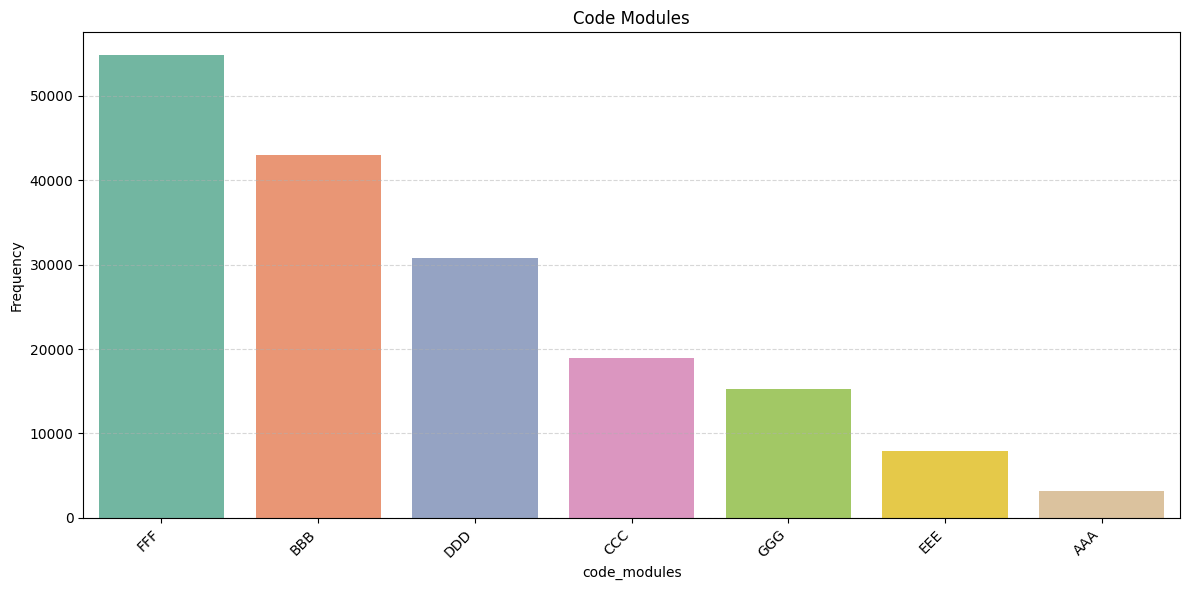

In [154]:
plt.figure(figsize=(12,6))
modules_count = data['code_module'].value_counts().sort_values(ascending=False)

sns.countplot(data=data, x='code_module', order=modules_count.index, palette='Set2')

plt.xlabel("code_modules")
plt.ylabel("Frequency")
plt.title("Code Modules")
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout() 
plt.show()

#### Code Presentation

/var/folders/32/wr6jfczj32q0c3fcn7fkrtvr0000gn/T/ipykernel_926/1979615046.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='code_presentation', order=presentation_count.index, palette='Set2')


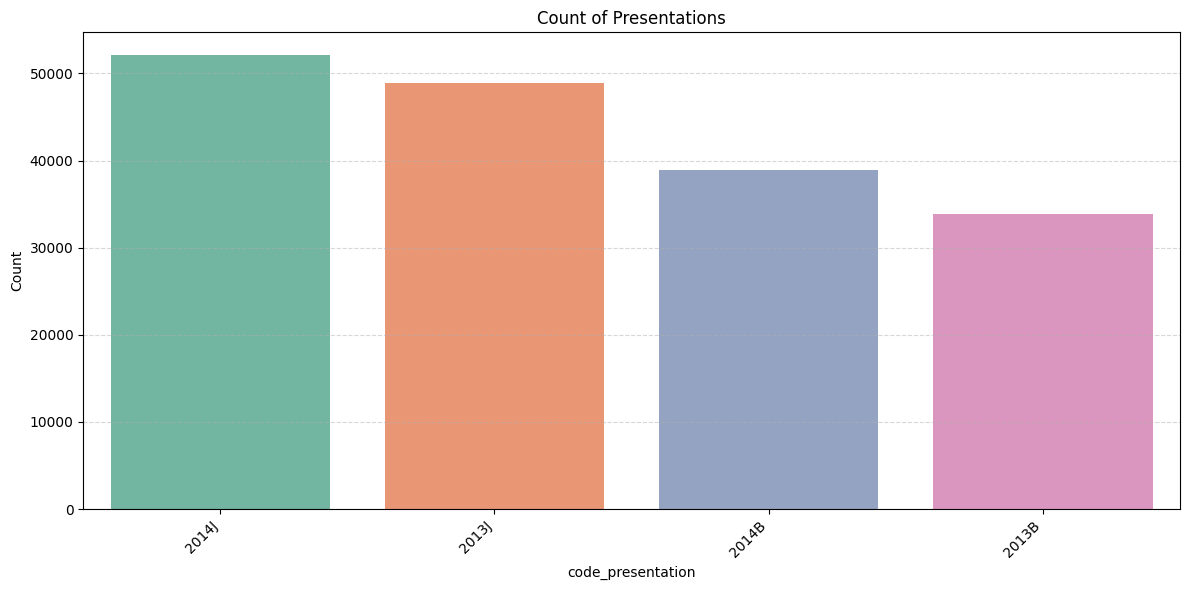

In [155]:
plt.figure(figsize=(12,6))
presentation_count = data['code_presentation'].value_counts().sort_values(ascending=False)

sns.countplot(data=data, x='code_presentation', order=presentation_count.index, palette='Set2')

plt.xlabel("code_presentation")
plt.ylabel("Count")
plt.title("Count of Presentations")
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout() 
plt.show()

#### Gender

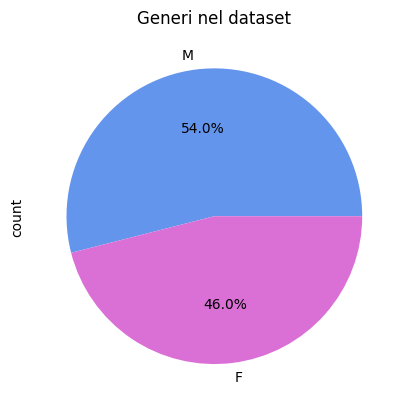

In [156]:
data['gender'].value_counts().plot.pie(autopct='%1.1f%%', colors=['cornflowerblue', 'orchid'])
plt.title("Generi nel dataset")
plt.show()

#### Id Student

In [157]:
data['id_student'].value_counts()

id_student
537811     28
554881     26
632074     25
443696     24
358075     24
           ..
694150      1
693812      1
680517      1
2156733     1
574663      1
Name: count, Length: 23344, dtype: int64

#### Highest Education

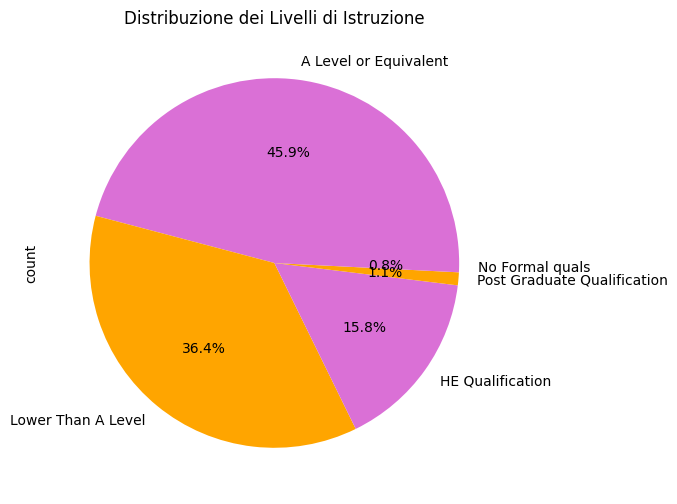

In [158]:
plt.figure(figsize=(12,6))
edu_count = data['highest_education'].value_counts().sort_values(ascending=False)

data['highest_education'].value_counts().plot.pie(autopct='%1.1f%%', colors = ['orchid', 'orange'])
plt.title("Distribuzione dei Livelli di Istruzione")
plt.show() 
plt.show()

Notiamo che No Formal Equals ans Post Gradute Qualification sono due gruppi estremamente piccoli che non possono aggiungere molta informazione, dunque li uniamo ai gruppi rispettivamente Lower A Level e HE Qualification.

In [159]:
data['highest_education'] = np.where(data['highest_education'] == 'No Formal quals', 'Lower Than A Level', data['highest_education']) 

In [160]:
data['highest_education'] = np.where(data['highest_education'] == 'Post Graduate Qualification', 'HE Qualification', data['highest_education'])

#### Region

/var/folders/32/wr6jfczj32q0c3fcn7fkrtvr0000gn/T/ipykernel_926/1834151763.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='region', order=region_count.index, palette='Set2')


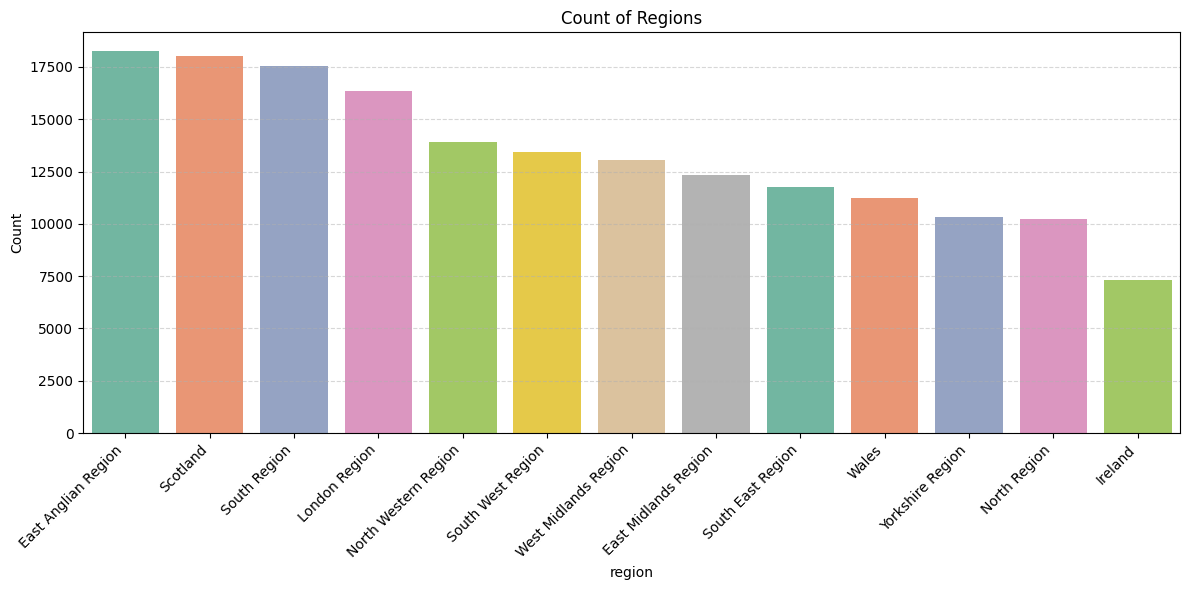

In [161]:
plt.figure(figsize=(12,6))
region_count = data['region'].value_counts().sort_values(ascending=False)

sns.countplot(data=data, x='region', order=region_count.index, palette='Set2')

plt.xlabel("region")
plt.ylabel("Count")
plt.title("Count of Regions")
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout() 
plt.show()

#### IMD Band

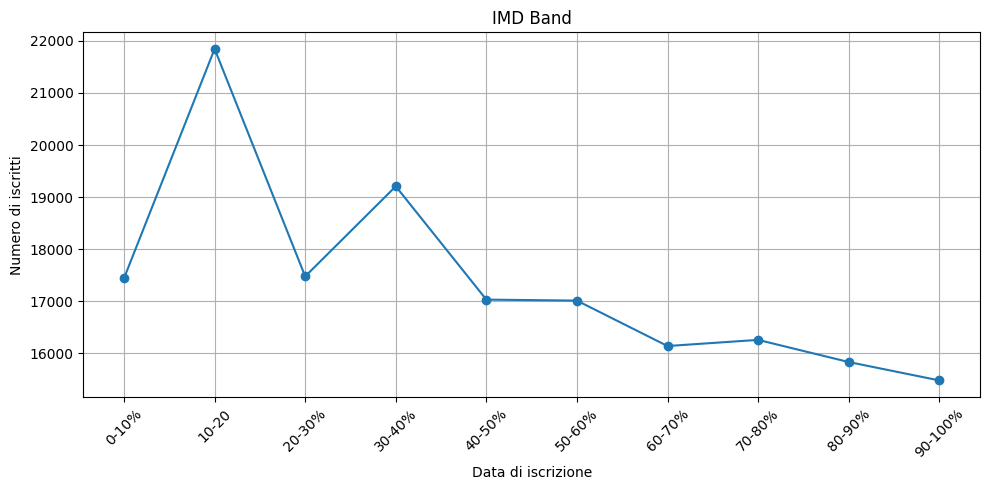

In [162]:
imd_band_count = data['imd_band'].value_counts().sort_index()

# Plotta
plt.figure(figsize=(10, 5))
plt.plot(imd_band_count.index, imd_band_count.values, marker='o')
plt.xlabel('Data di iscrizione')
plt.ylabel('Numero di iscritti')
plt.title('IMD Band')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)

#### Age Band

/var/folders/32/wr6jfczj32q0c3fcn7fkrtvr0000gn/T/ipykernel_926/4015064364.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='age_band', order=age_band_count.index, palette='Set2')


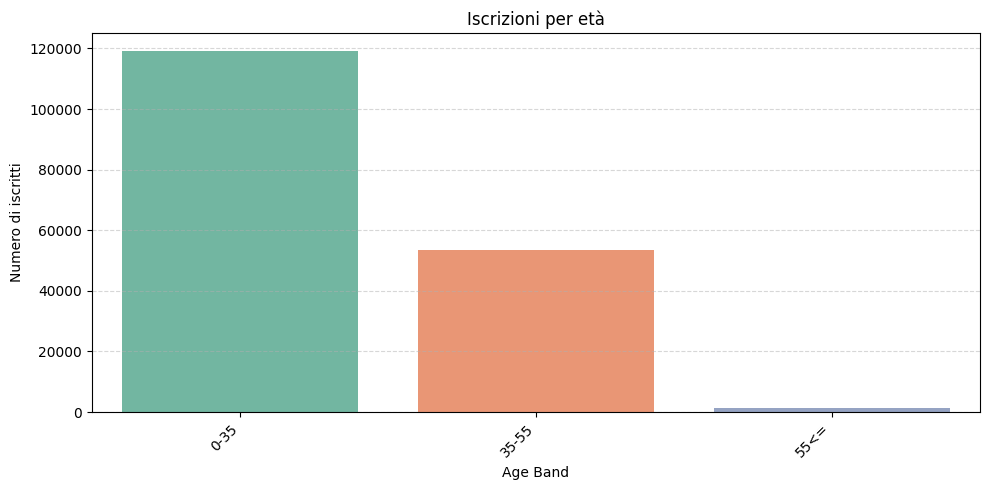

In [163]:
age_band_count = data['age_band'].value_counts().sort_values(ascending=False)

# Plotta
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='age_band', order=age_band_count.index, palette='Set2')
plt.xlabel('Age Band')
plt.ylabel('Numero di iscritti')
plt.title('Iscrizioni per età')
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout() 
plt.show()

Notiamo che i valori superiori a 55 anni sono molti pochi, dunque li aggreghiamo all'age band 35-55 che rinominiamo per includere i nuovi valori.

In [164]:
data['age_band'] = np.where(data['age_band'] == '55<=', '35-55', data['age_band'])
data['age_band'] = np.where(data['age_band'] == '35-55', '35+', data['age_band'])

#### Disability

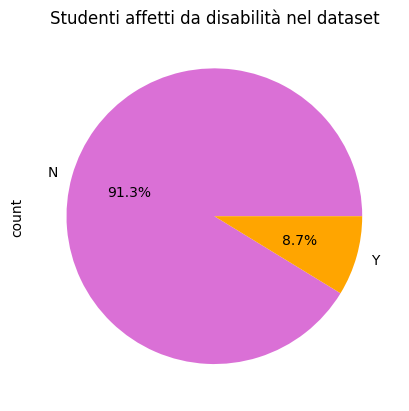

In [165]:
data['disability'].value_counts().plot.pie(autopct='%1.1f%%', colors = ['orchid', 'orange'])
plt.title("Studenti affetti da disabilità nel dataset")
plt.show()

#### Assessment Type

/var/folders/32/wr6jfczj32q0c3fcn7fkrtvr0000gn/T/ipykernel_926/583896688.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='assessment_type', palette='Set2')


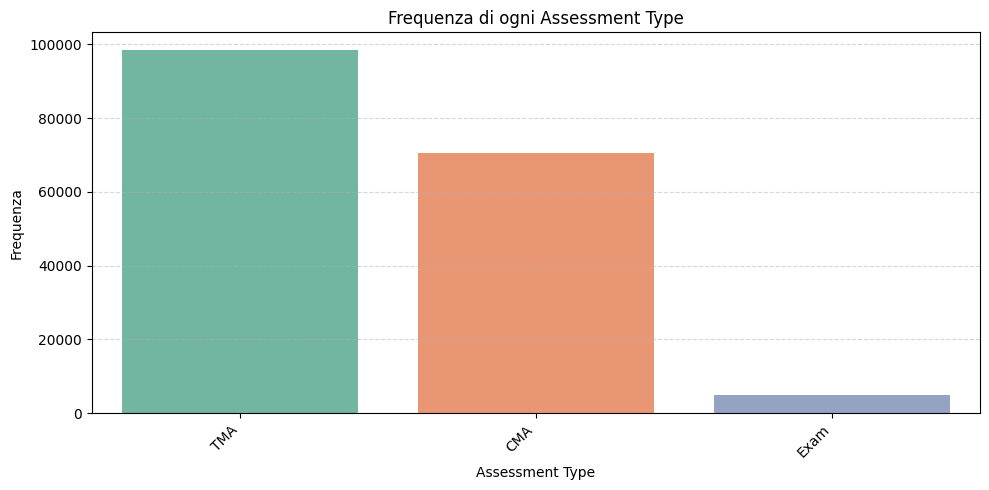

In [166]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='assessment_type', palette='Set2')

plt.xlabel('Assessment Type')
plt.ylabel('Frequenza')
plt.title('Frequenza di ogni Assessment Type')
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout() 
plt.show()

#### Is Banked

is_banked
0    98.98126
1     1.01874
Name: count, dtype: float64


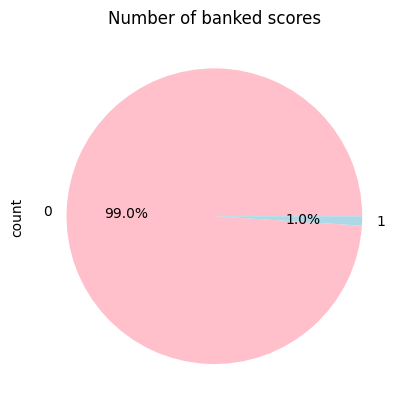

In [167]:
print(data['is_banked'].value_counts()*100/len(data))
data['is_banked'].value_counts().plot.pie(autopct='%1.1f%%', colors = ['pink', 'lightblue'])
plt.title("Number of banked scores")
plt.show()

L'informazione non è rilevante per la nostra ricerca, oltre a riguardare una percentuale non significativa di studenti, dunque droppiamo la colonna.

In [168]:
data = data.drop('is_banked', axis=1)

#### Final Result

In [169]:
data['final_result'].value_counts()

final_result
Pass           106011
Fail            28367
Distinction     26330
Withdrawn       13036
Name: count, dtype: int64

/var/folders/32/wr6jfczj32q0c3fcn7fkrtvr0000gn/T/ipykernel_926/399751108.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='final_result', palette='Set2')


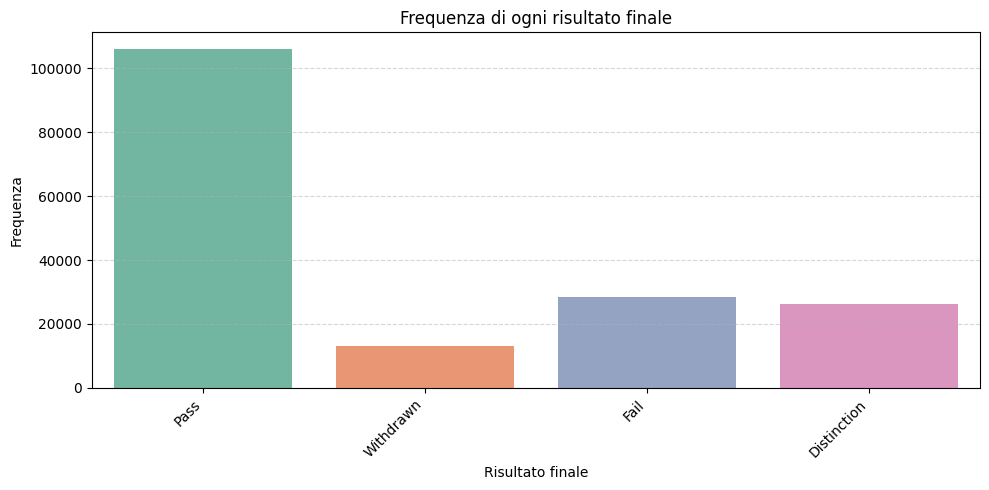

In [170]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='final_result', palette='Set2')

plt.xlabel('Risultato finale')
plt.ylabel('Frequenza')
plt.title('Frequenza di ogni risultato finale')
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout() 
plt.show()

### Variabili Numeriche

In [171]:
numerical_columns = data.select_dtypes(include=['number']).columns

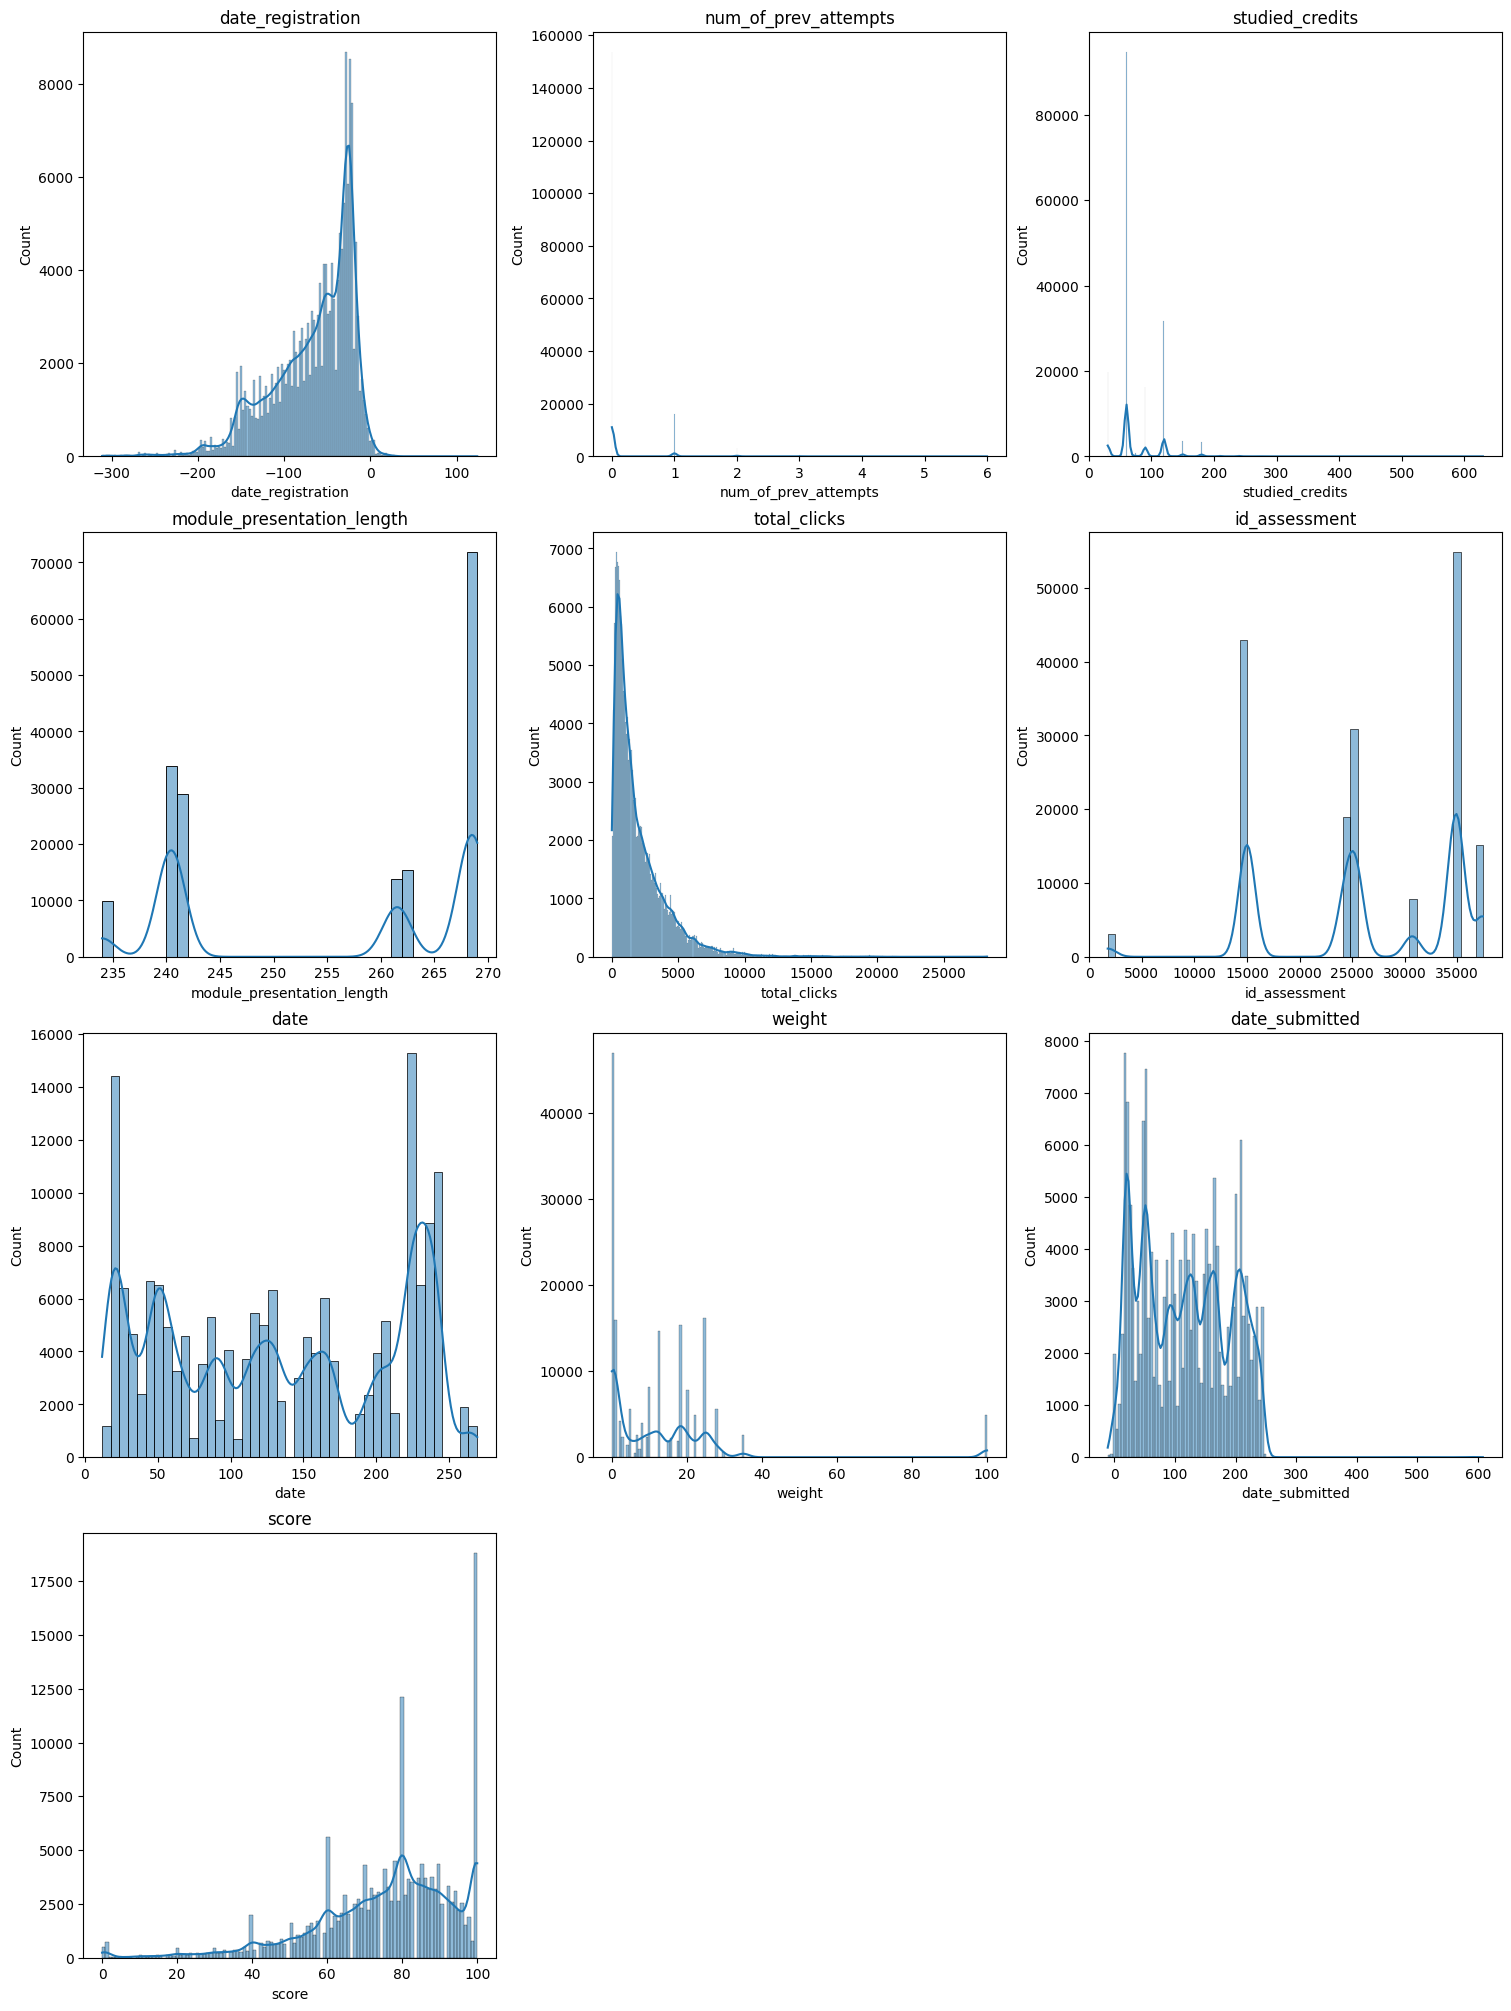

In [ ]:
numerical_columns = data.select_dtypes(include=['number']).columns
columns = 3
rows = (len(numerical_columns) + columns - 1) // columns

fig, axes = plt.subplots(rows, columns, figsize= (15, 5*rows), constrained_layout = True)
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(data[col], ax = axes[i], kde = True)
    axes[i].set_title(col)
    
for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])
    
plt.show()

Osservazioni:
- Date Registration ha quasi una distribuzione normale
- Total Clicks chiara distribuzione zipfiana
- Date chiaramente bimodale

Correlazioni con score:

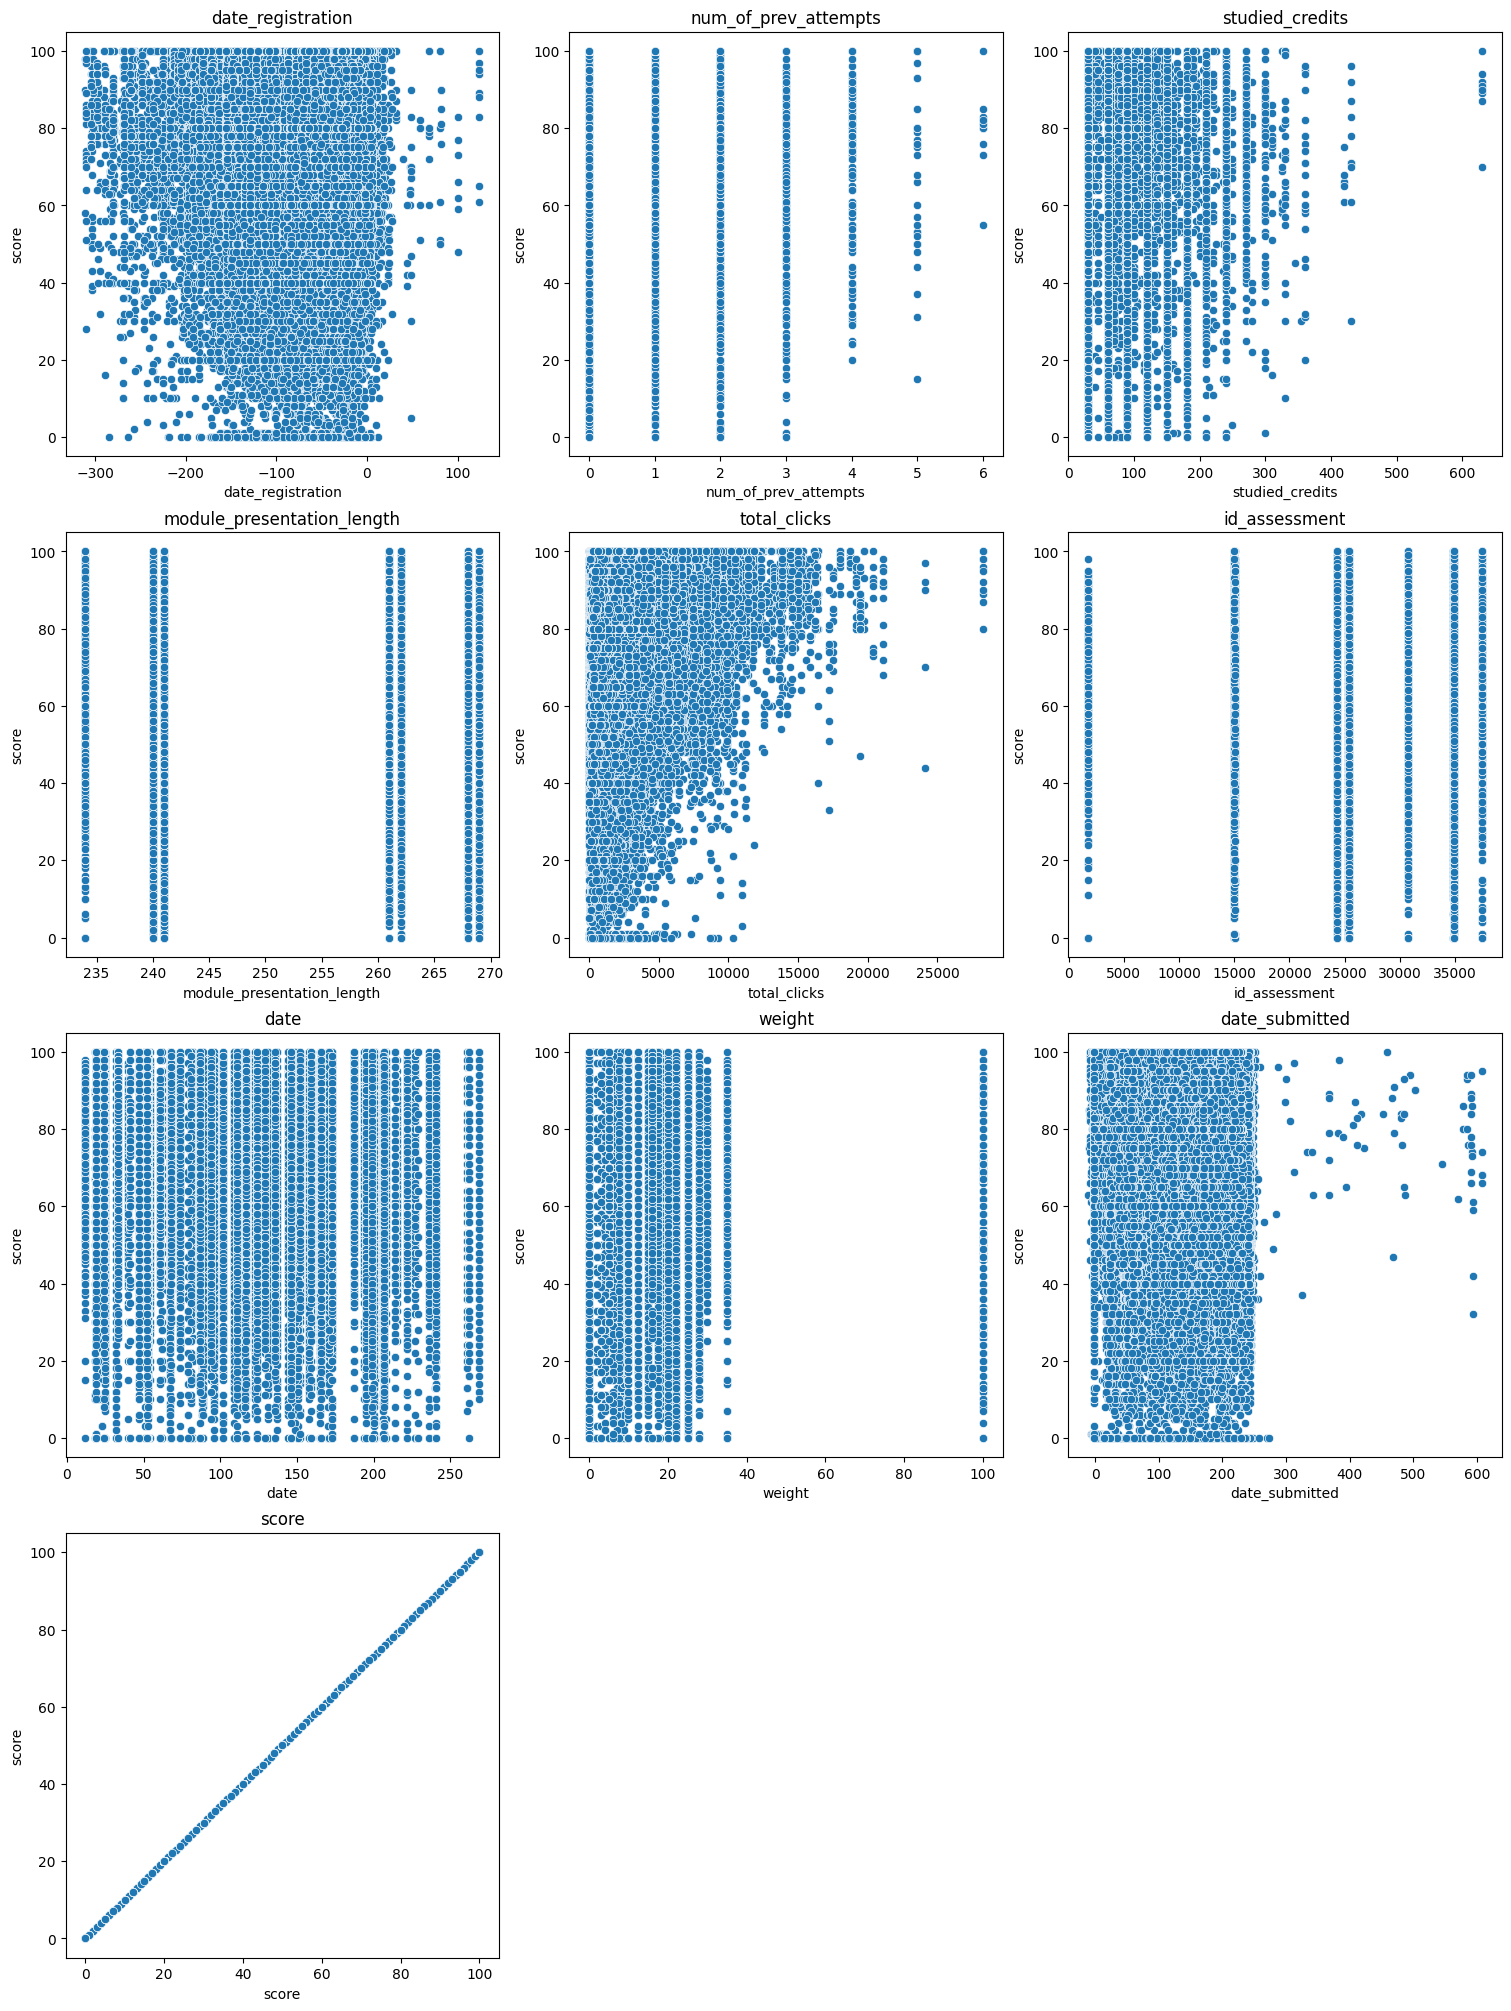

In [173]:
columns = 3
rows = (len(numerical_columns) + columns - 1) // columns

fig, axes = plt.subplots(rows, columns, figsize= (15, 5*rows), constrained_layout = True)
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.scatterplot(data = data, x = col, y = 'score', ax=axes[i])
    axes[i].set_title(col)
    
for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])
    
plt.show()

Correlazioni in generale:

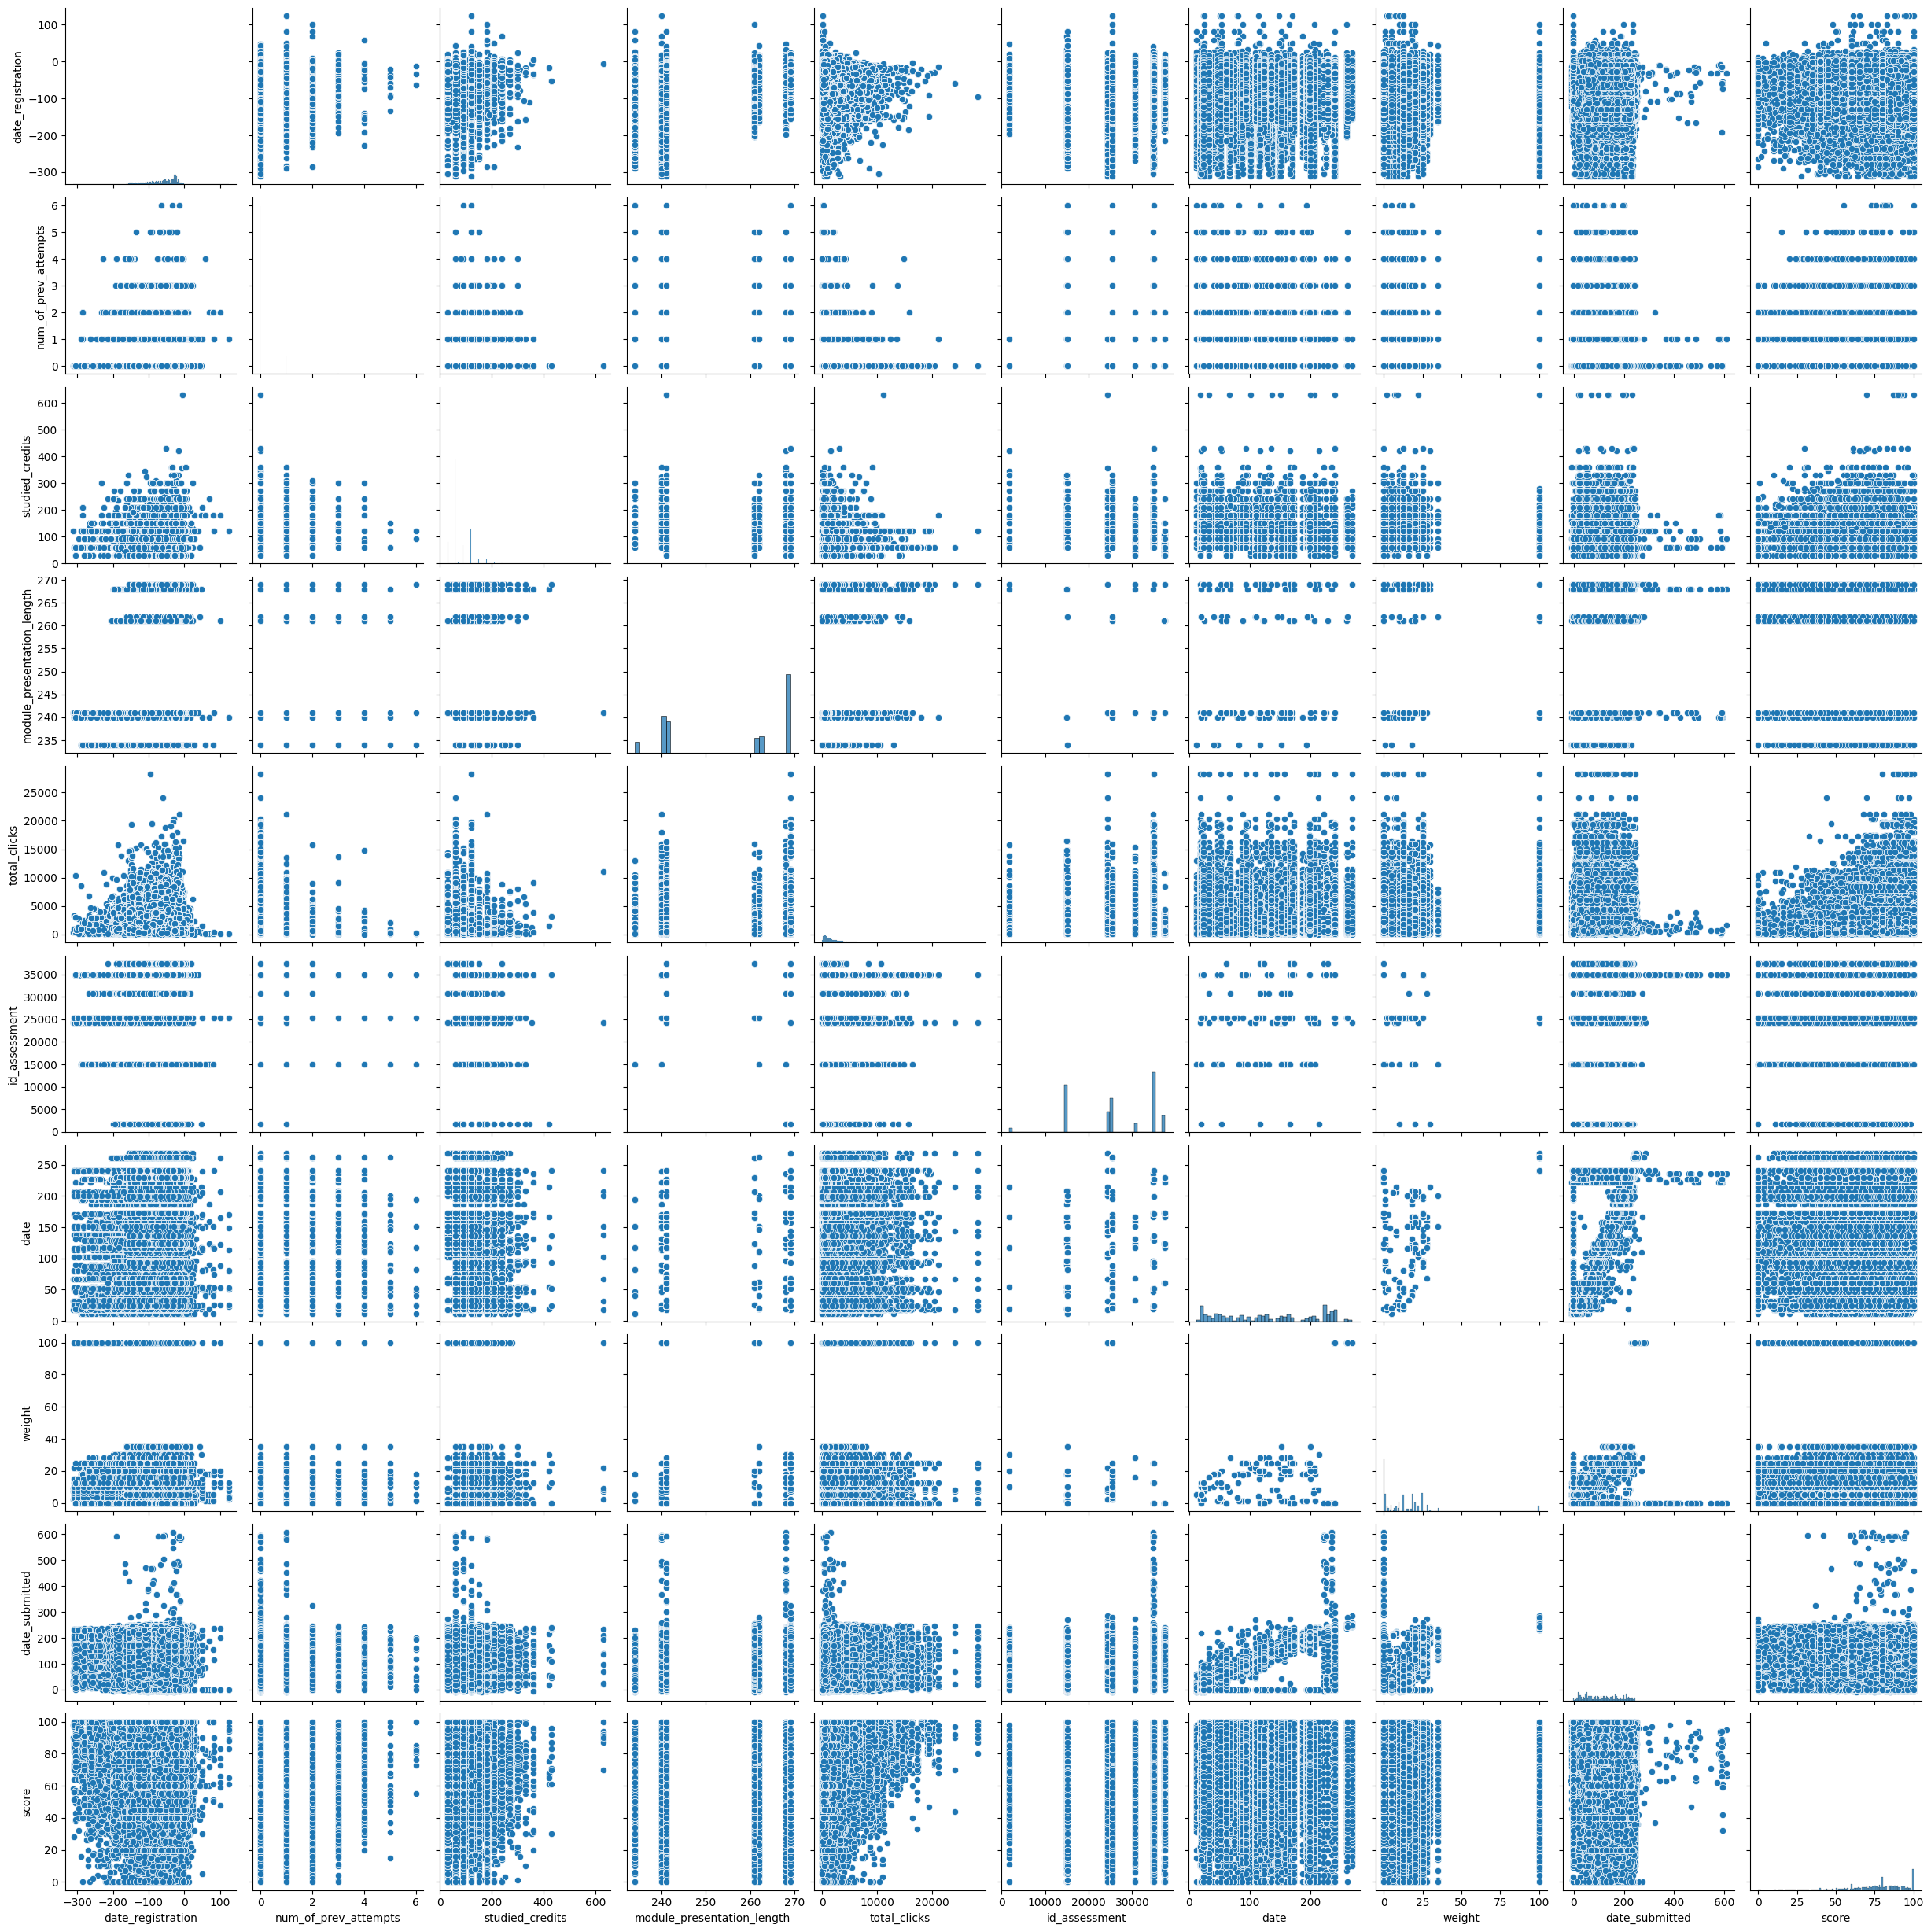

In [174]:
numerical_data = data[numerical_columns]
sns.pairplot(numerical_data)
plt.show()

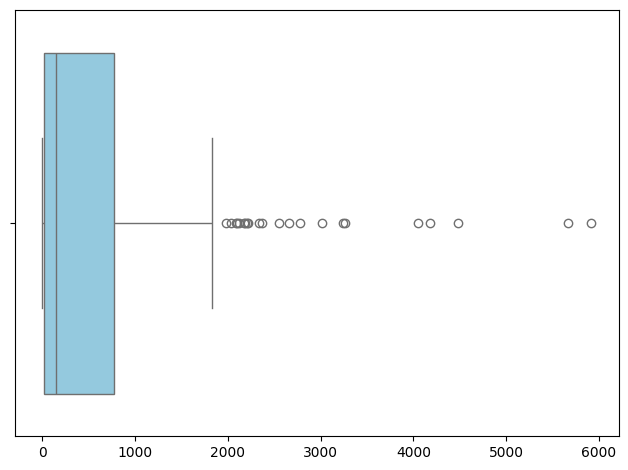

In [175]:
# Date Registration
iscrizioni_per_data = data['date_registration'].value_counts().sort_index()

sns.boxplot(x=iscrizioni_per_data.values, color='skyblue')
axes[1].set_title('Distribuzione numero iscritti')
axes[1].set_xlabel('Numero di iscritti')

plt.tight_layout()
plt.show()

Date registration e total_clicks

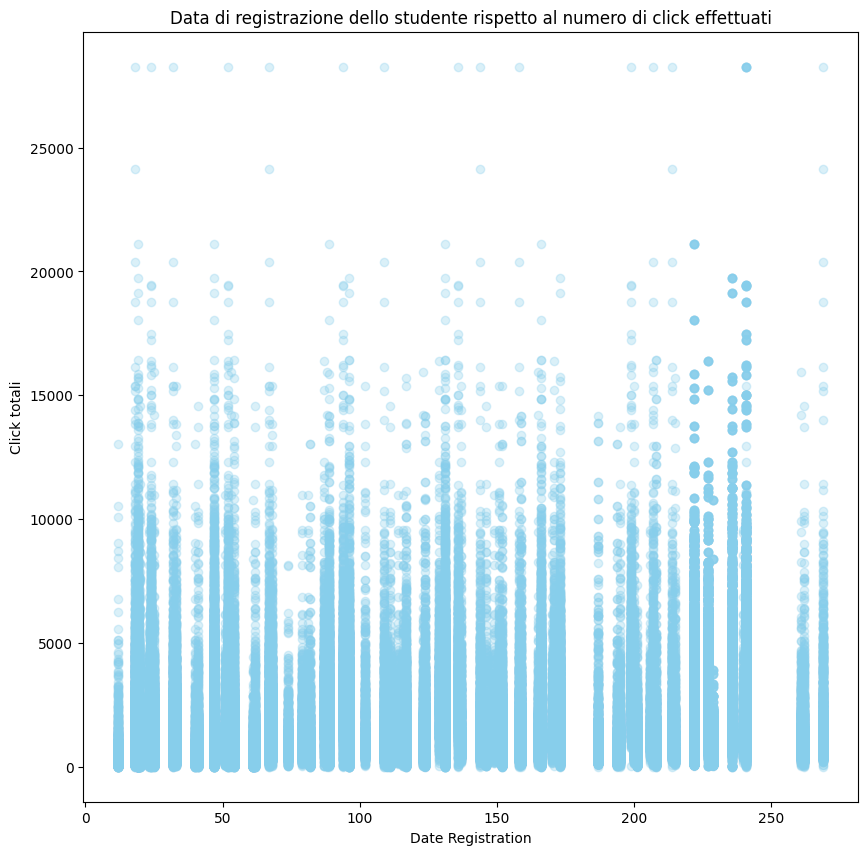

In [176]:
plt.figure(figsize=(10, 10))
plt.title('Data di registrazione dello studente rispetto al numero di click effettuati')
plt.ylabel("Click totali")
plt.xlabel("Date Registration")
plt.scatter(data=data, x='date', y='total_clicks', alpha=.3,color="skyblue")
plt.show()

La variabile è fortemente granularizzata, si opta quindi per una discretizzazione in categorie:
- Iscrizione fortemente anticipata
- Iscrizione anticipata
- Iscrizione congruente (all'inizio del corso)
- Iscrizione tardiva
- Iscrizione fortemente tardiva

In [ ]:
data['registration'] = pd.qcut(data['date_registration'], q = 5, labels=['iscrizione_fortemente_anticipata', 
                                                                         'iscrizione_anticipata', 
                                                                         'iscrizione_congruente',
                                                                         'iscrizione_tardiva',
                                                                         'iscrizione_fortemente_tardiva'])

In [178]:
data = data.drop('date_registration', axis = 1)

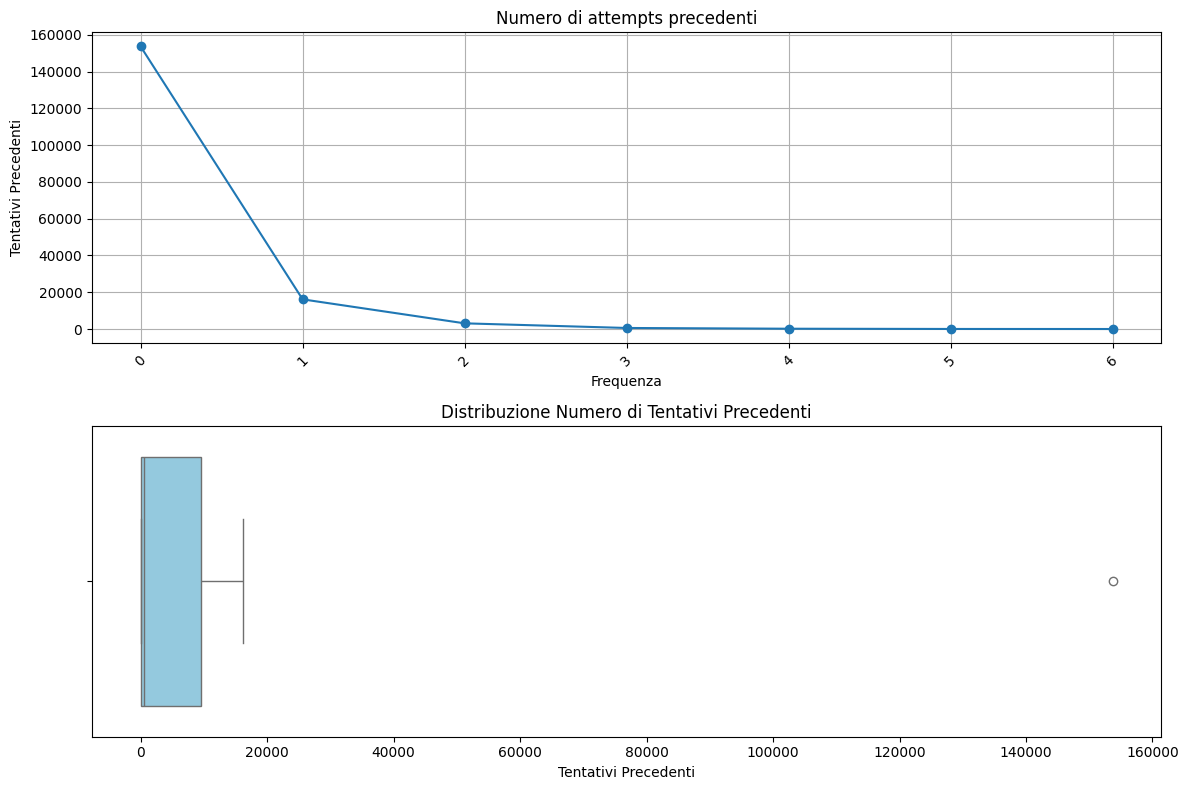

In [179]:
# Number of Previous Attempts
previous_attempts = data['num_of_prev_attempts'].value_counts().sort_index()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

axes[0].plot(previous_attempts.index, previous_attempts.values, marker='o')
axes[0].set_title('Numero di attempts precedenti')
axes[0].set_xlabel('Frequenza')
axes[0].set_ylabel('Tentativi Precedenti')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x=previous_attempts.values, ax=axes[1], color='skyblue')
axes[1].set_title('Distribuzione Numero di Tentativi Precedenti')
axes[1].set_xlabel('Tentativi Precedenti')

plt.tight_layout()
plt.show()

Studied credits è una variabile molto particolare: specifica ma generale. Per ora la lasciamo così, la aggregheremo in futuro.

In [180]:
# Esplora i valori unici
print(data['studied_credits'].value_counts())


studied_credits
60     94703
120    31584
30     19753
90     16272
150     3564
180     3296
75       683
240      652
70       641
210      588
130      201
80       183
45       179
270      168
100      161
135      135
40       108
160       93
300       93
110       72
105       60
195       59
165       47
190       44
220       39
145       38
140       35
330       28
250       26
360       26
200       25
170       23
50        19
95        15
115       14
155       14
310       13
85        12
280       12
325       11
430       11
225        9
630        9
55         6
235        5
420        5
65         4
215        3
355        1
345        1
205        1
Name: count, dtype: int64


Rapporto tra total_clicks e studied credits

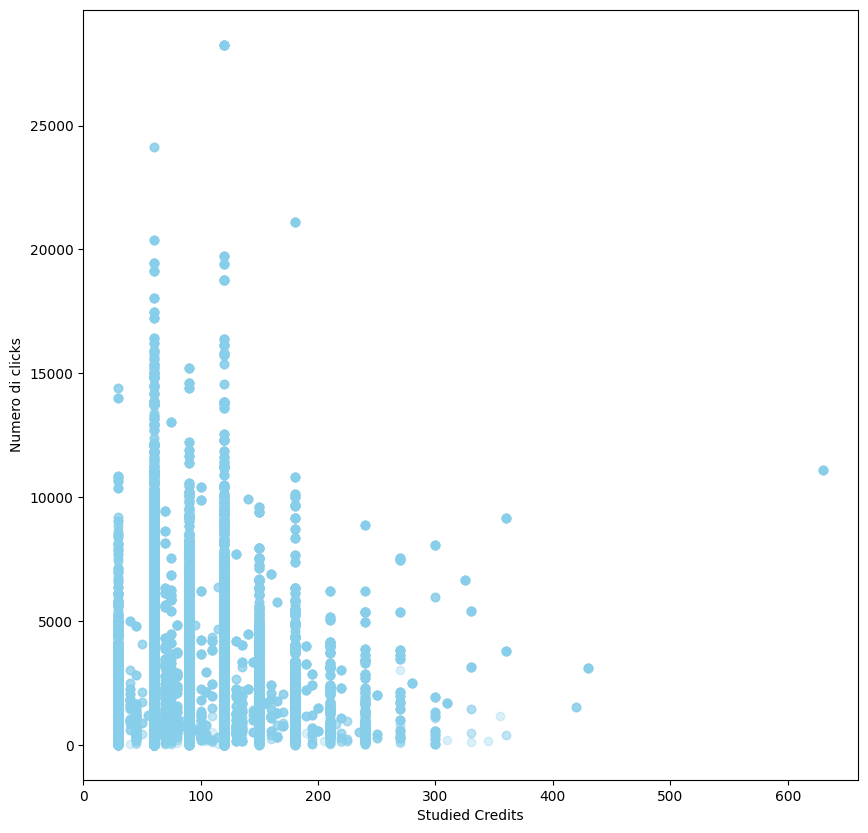

In [181]:
plt.figure(figsize=(10, 10))
plt.xlabel("Studied Credits")
plt.ylabel("Numero di clicks")
plt.scatter(data=data, x='studied_credits', y='total_clicks', alpha=.3,color="skyblue")
plt.show()

In [182]:
# Granularità gestibile, manteniamo la variabile così come è
data['module_presentation_length'].unique()

array([268, 269, 240, 234, 241, 262, 261])

<Axes: xlabel='total_clicks', ylabel='Count'>

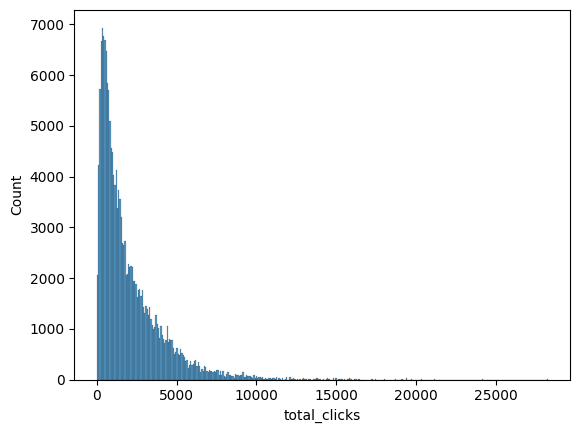

In [183]:
sns.histplot(data['total_clicks'])

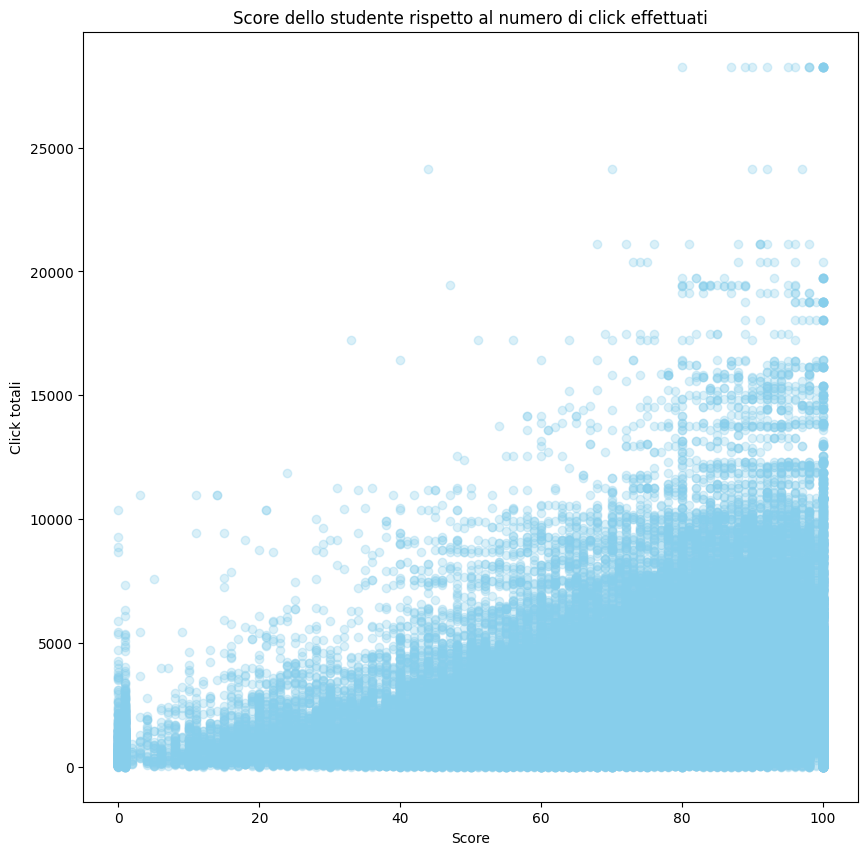

Correlazione tra il numero di clicks e lo score finale 0.1880943426013139


In [184]:
plt.figure(figsize=(10, 10))
plt.title('Score dello studente rispetto al numero di click effettuati')
plt.xlabel("Score")
plt.ylabel("Click totali")
plt.scatter(data=data, y='total_clicks', x='score', alpha=.3,color="skyblue")
plt.show()
print('Correlazione tra il numero di clicks e lo score finale', data['total_clicks'].astype(int).corr(data['score'].astype(int)))

In [185]:
# Data la forte granularità dei valori in total_clicks, creiamo una nuova variabile 'engagement' discretizzando la variabile in 5 bins
data['total_clicks'] = pd.qcut(data['total_clicks'], q= 5, labels=['very_low', 'low', 'average', 'high', 'very_high'])

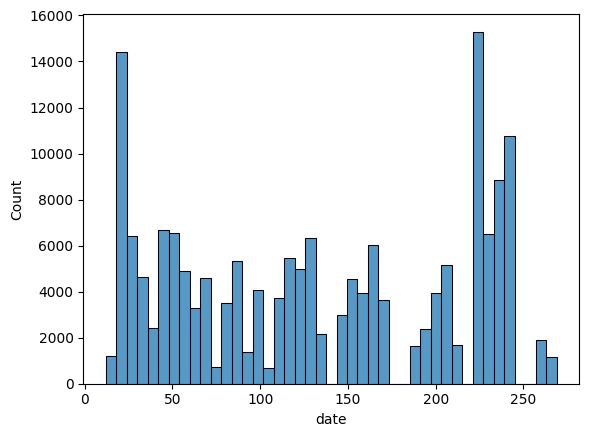

In [186]:
sns.histplot(data['date'])
plt.show()

/var/folders/32/wr6jfczj32q0c3fcn7fkrtvr0000gn/T/ipykernel_926/4087414398.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='date', order=data['date'].value_counts().index, palette='Set2')


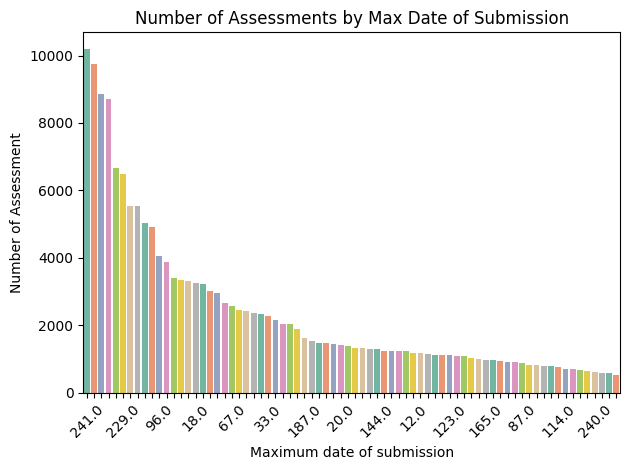

In [187]:
# Date variable
sns.countplot(data=data, x='date', order=data['date'].value_counts().index, palette='Set2')
plt.xlabel('Maximum date of submission')
plt.ylabel('Number of Assessment')
plt.title('Number of Assessments by Max Date of Submission')
plt.xticks(rotation=45)
labels = plt.gca().get_xticklabels()
for i, label in enumerate(labels):
    if i % 5 != 0:  # Mostra solo ogni 5ª etichetta
        label.set_visible(False)
plt.tight_layout()
plt.show()

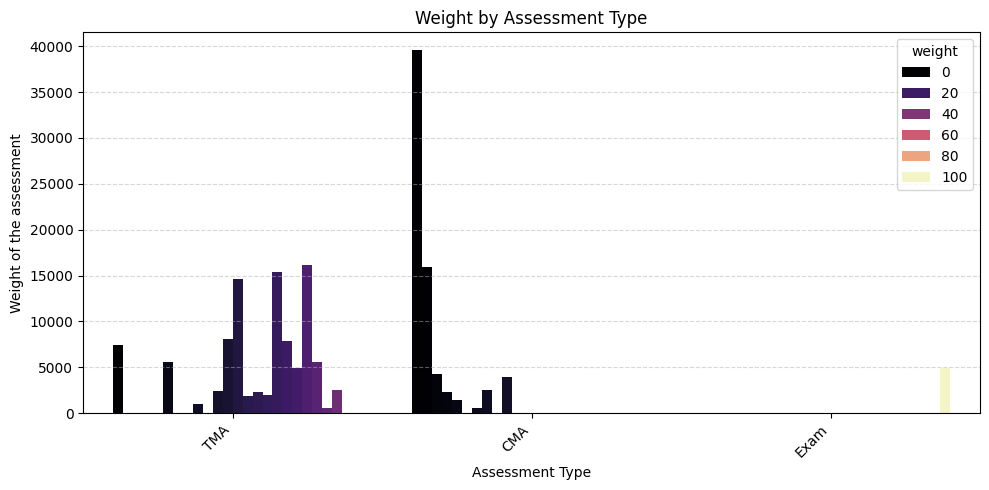

In [188]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='assessment_type', hue='weight', palette='magma')

plt.xlabel('Assessment Type')
plt.ylabel('Weight of the assessment')
plt.title('Weight by Assessment Type')
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout() 
plt.show()

/var/folders/32/wr6jfczj32q0c3fcn7fkrtvr0000gn/T/ipykernel_926/683941248.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='date_submitted', order=data['date_submitted'].value_counts().index, palette='Set2')


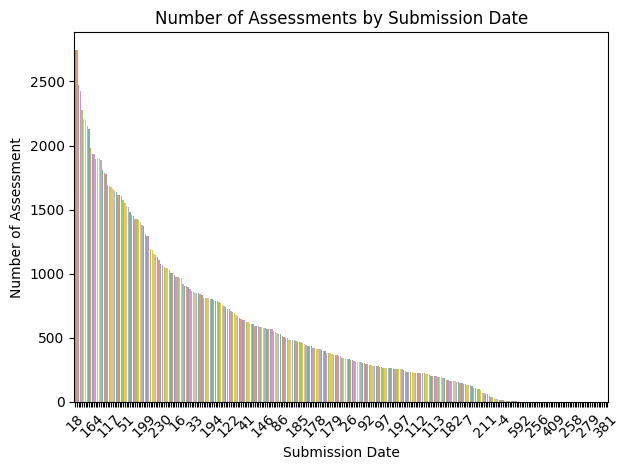

In [189]:
# date_submitted
sns.countplot(data=data, x='date_submitted', order=data['date_submitted'].value_counts().index, palette='Set2')
plt.xlabel('Submission Date')
plt.ylabel('Number of Assessment')
plt.title('Number of Assessments by Submission Date')
plt.xticks(rotation=45)
labels = plt.gca().get_xticklabels()
for i, label in enumerate(labels):
    if i % 10 != 0:  # Mostra solo ogni 5ª etichetta
        label.set_visible(False)
plt.tight_layout()
plt.show()

Le informazioni contenute in date_submitted e date possono essere riassunte in un'unica colonna che faccia riferimento a se l'assessment è stato consegnato in tempo oppure no, dunque sommiamo le due colonne. Prima calcoliamo la correlazione con score..

Correlazione tra il ritardo nella consegna ed il voto finale -0.16595347734609198


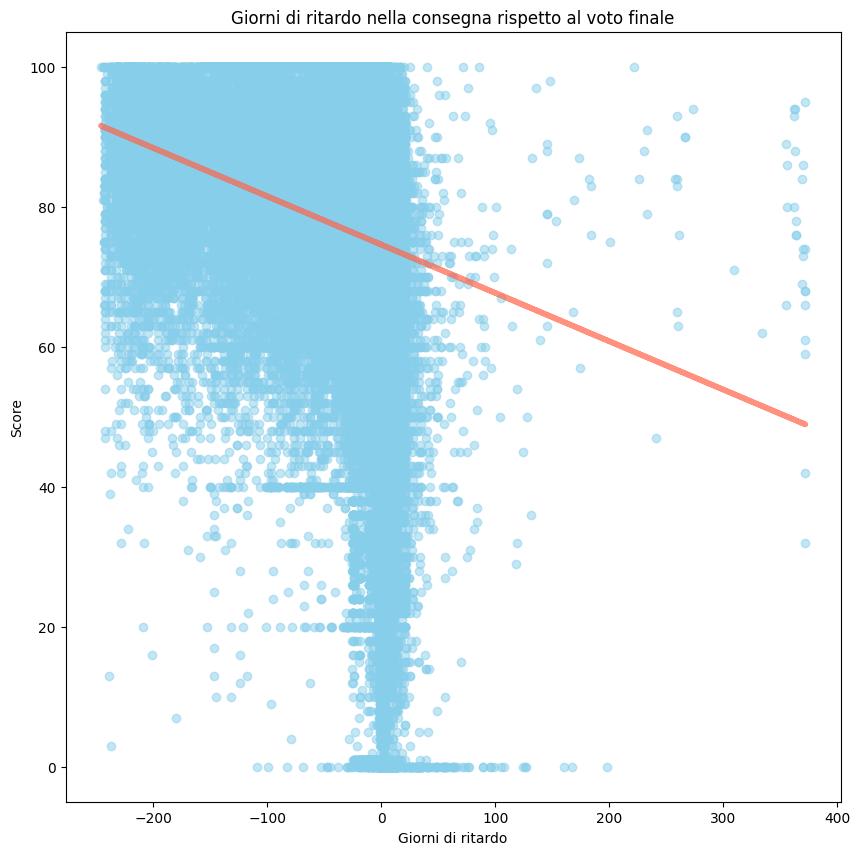

In [190]:
data['days_late'] = data['date_submitted'] - data['date']
print('Correlazione tra il ritardo nella consegna ed il voto finale', data['days_late'].astype(int).corr(data['score'].astype(int)))

plt.figure(figsize=(10, 10))
x = np.array(data['days_late'].astype(int))
y = np.array(data['score'].astype(int))
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y, alpha=.5, color='skyblue')
plt.title('Giorni di ritardo nella consegna rispetto al voto finale')
plt.xlabel("Giorni di ritardo")
plt.ylabel("Score")
plt.plot(x, m*x + b, color='tomato', lw=4, alpha=.7)
plt.show()
data.drop('days_late',axis=1,inplace=True)

In [191]:
# Stabiliamo un valore predefinito da sostituire in un singolo caso
data['submission'] = 'submission_on_time'
data.loc[data['date_submitted'] > data['date'], 'submission'] = 'late_submission'

In [192]:
data = data.drop(['date', 'date_submitted'], axis = 1)

In [193]:
data["score"].describe()

count    173744.000000
mean         75.731968
std          18.936644
min           0.000000
25%          65.000000
50%          80.000000
75%          90.000000
max         100.000000
Name: score, dtype: float64

In [194]:
data['score'].value_counts()

score
100.0    18795
80.0     12103
60.0      5608
78.0      4501
90.0      4365
         ...  
4.0         28
5.0         25
7.0         24
3.0         17
2.0         12
Name: count, Length: 101, dtype: int64

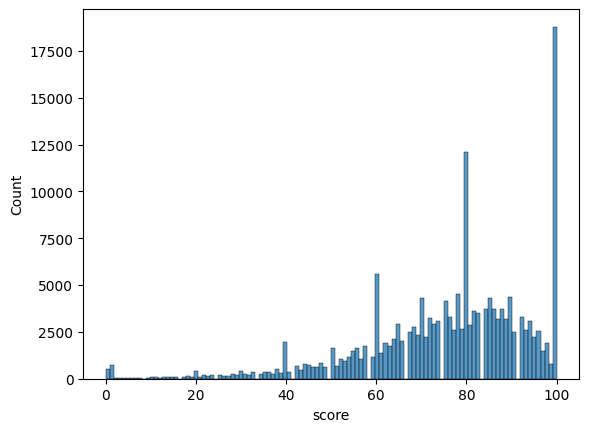

In [195]:
sns.histplot(data['score'])
plt.show()

In [196]:
data['score'].isna().sum()

np.int64(0)

## Data Understanding: Univariate Analysis

imd band by final result

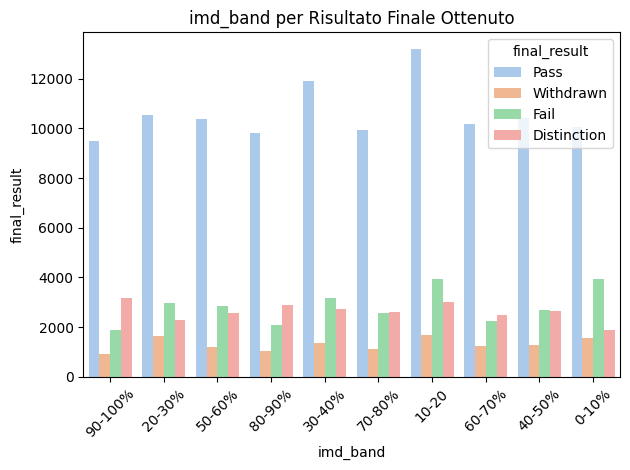

In [197]:
sns.countplot(data = data, x = 'imd_band', hue = 'final_result', palette='pastel')
plt.xlabel('imd_band')
plt.ylabel('final_result')
plt.title('imd_band per Risultato Finale Ottenuto')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

disability by final result

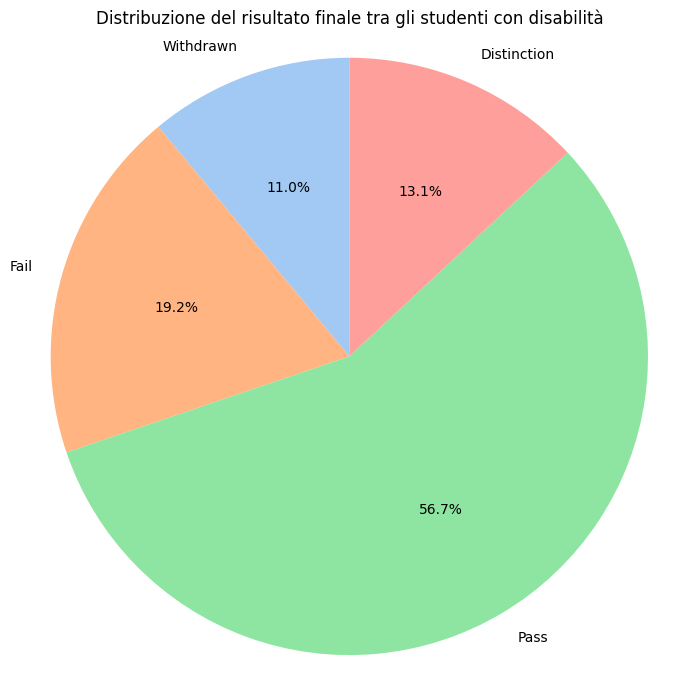

In [198]:
# Filtro solo gli studenti con disabilità
disabled_students = data[data['disability'] == 'Y']

# Calcolo distribuzione in percentuale
result_counts = disabled_students['final_result'].value_counts(normalize=True) * 100

# Ordina se vuoi (opzionale)
result_counts = result_counts.reindex(['Withdrawn', 'Fail', 'Pass', 'Distinction']).dropna()

# Etichette e valori
labels = result_counts.index
sizes = result_counts.values

# Plot
plt.figure(figsize=(7,7))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',       # Mostra percentuali con 1 cifra decimale
    startangle=90,           # Inizia da ore 12
    colors=sns.color_palette('pastel')  # Palette soft
)
plt.title("Distribuzione del risultato finale tra gli studenti con disabilità")
plt.axis('equal')  # Mantiene il cerchio perfetto
plt.tight_layout()
plt.show()


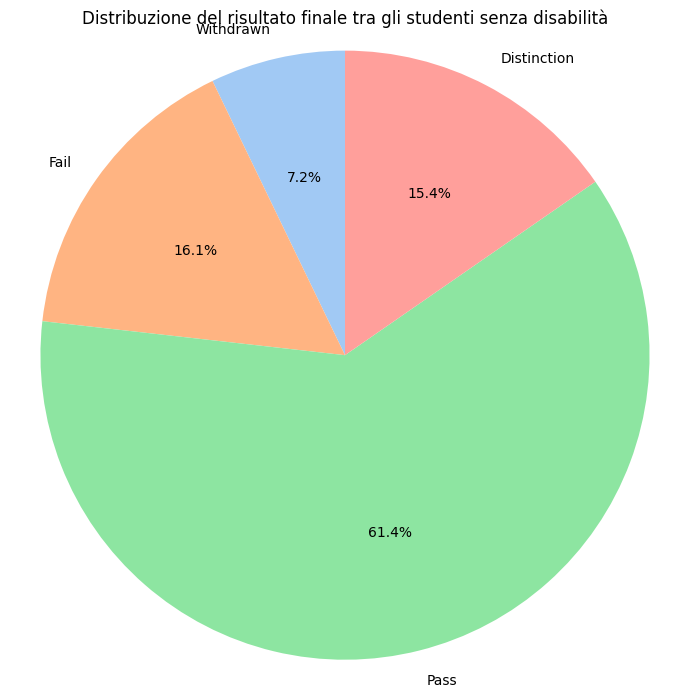

In [199]:
# Lo paragono ai rate degli studenti senza disabilità
# Filtro solo gli studenti con disabilità
abled_students = data[data['disability'] == 'N']

# Calcolo distribuzione in percentuale
result_counts = abled_students['final_result'].value_counts(normalize=True) * 100

# Ordina se vuoi (opzionale)
result_counts = result_counts.reindex(['Withdrawn', 'Fail', 'Pass', 'Distinction']).dropna()

# Etichette e valori
labels = result_counts.index
sizes = result_counts.values

# Plot
plt.figure(figsize=(7,7))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',       # Mostra percentuali con 1 cifra decimale
    startangle=90,           # Inizia da ore 12
    colors=sns.color_palette('pastel')  # Palette soft
)
plt.title("Distribuzione del risultato finale tra gli studenti senza disabilità")
plt.axis('equal')  # Mantiene il cerchio perfetto
plt.tight_layout()
plt.show()


age by final result

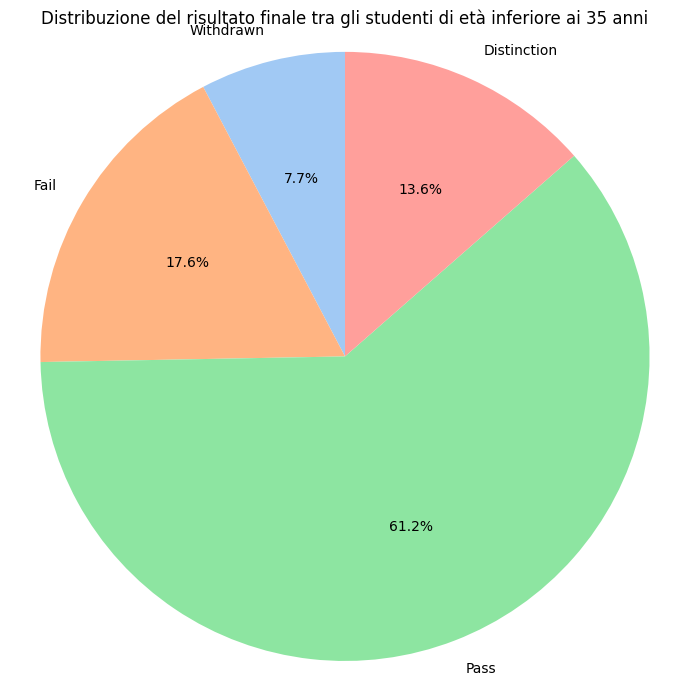

In [200]:
under_35_students = data[data['age_band'] == '0-35']

# Calcolo distribuzione in percentuale
result_counts = under_35_students['final_result'].value_counts(normalize=True) * 100

# Ordina se vuoi (opzionale)
result_counts = result_counts.reindex(['Withdrawn', 'Fail', 'Pass', 'Distinction']).dropna()

# Etichette e valori
labels = result_counts.index
sizes = result_counts.values

# Plot
plt.figure(figsize=(7,7))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',       # Mostra percentuali con 1 cifra decimale
    startangle=90,           # Inizia da ore 12
    colors=sns.color_palette('pastel')  # Palette soft
)
plt.title("Distribuzione del risultato finale tra gli studenti di età inferiore ai 35 anni")
plt.axis('equal')  # Mantiene il cerchio perfetto
plt.tight_layout()
plt.show()

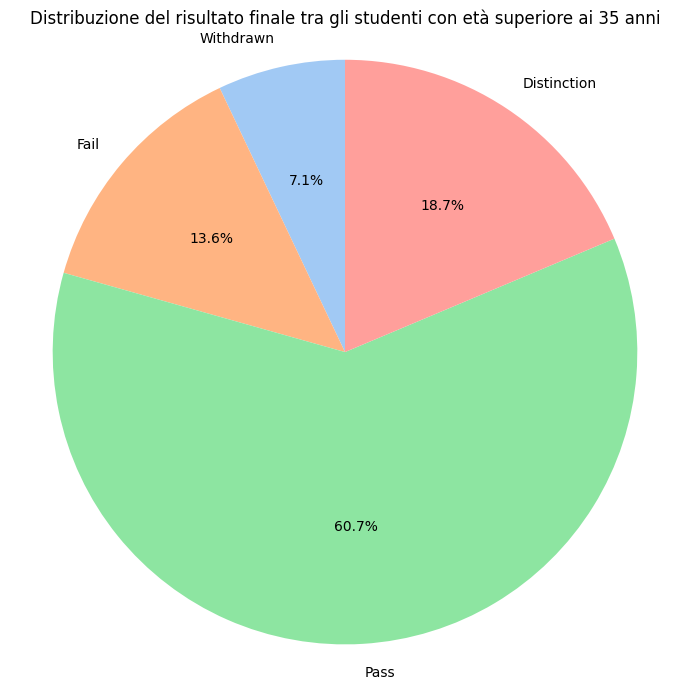

In [201]:
over_35_students = data[data['age_band'] == '35+']

# Calcolo distribuzione in percentuale
result_counts = over_35_students['final_result'].value_counts(normalize=True) * 100

# Ordina se vuoi (opzionale)
result_counts = result_counts.reindex(['Withdrawn', 'Fail', 'Pass', 'Distinction']).dropna()

# Etichette e valori
labels = result_counts.index
sizes = result_counts.values

# Plot
plt.figure(figsize=(7,7))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',       
    startangle=90,           
    colors=sns.color_palette('pastel')  # Palette soft
)
plt.title("Distribuzione del risultato finale tra gli studenti con età superiore ai 35 anni")
plt.axis('equal')  # Mantiene il cerchio perfetto
plt.tight_layout()
plt.show()

## Data Understanding: Multivariate Analysis

Dato che la nostra analisi si focalizza sul predirre l'esito del corso per uno studente, visualizziamo i rapporti tra le variabili e final_result. 

In [202]:
cat_columns = data.select_dtypes('object').columns
cols_to_drop = ['final_result', 'id_student']

In [203]:
cat_columns = cat_columns.drop(cols_to_drop)
cols = 3
rows = (len(cat_columns)+cols-1)//cols

/var/folders/32/wr6jfczj32q0c3fcn7fkrtvr0000gn/T/ipykernel_926/2470870882.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


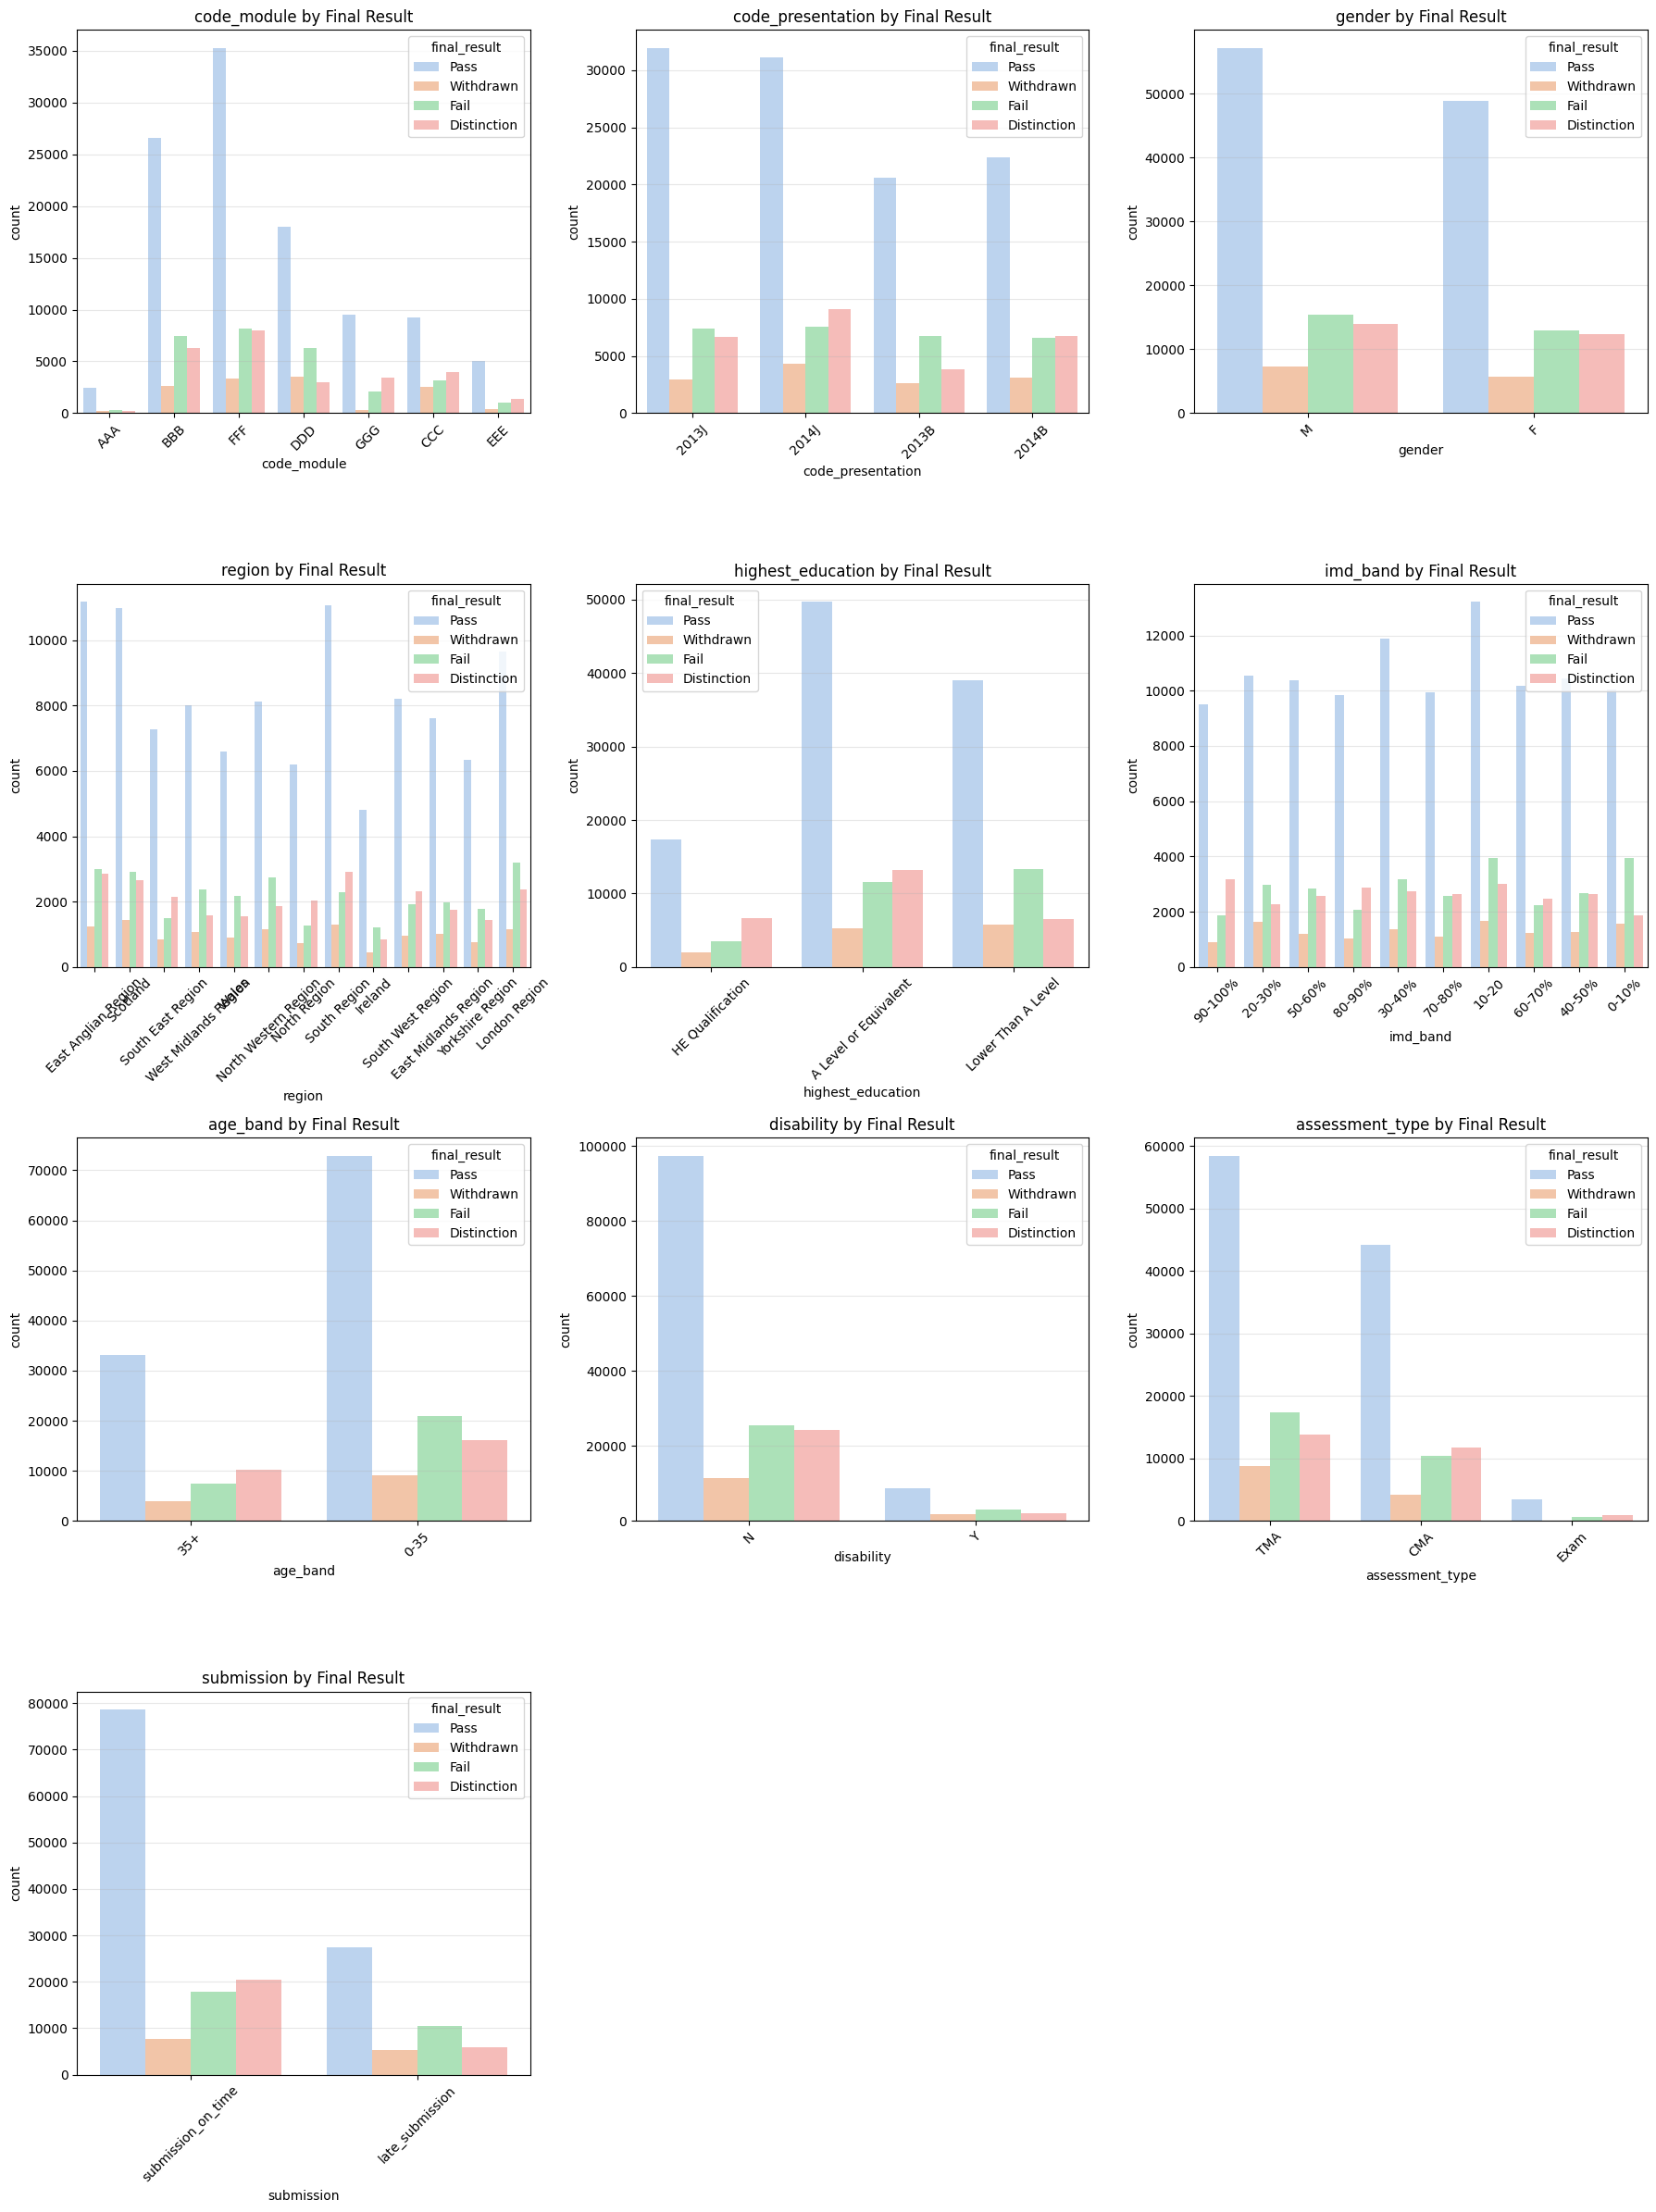

In [204]:
# Sempre impostare figsize sennò i grafici sono tutti appiccicati
# Prima le righe e poi le colonne
fig, axs = plt.subplots(rows, cols, figsize = (18,6*rows), constrained_layout = True)

# Necessario fare il flattening dell'array axs perchè è un array a due coordinate,
# dunque se si vuole iterarci sopra come nel codice sotto deve essere ridotto ad una
axs = axs.flatten()

for i, col in enumerate(cat_columns): 
    # Il parametro alpha si occupa della trasparenza del plot
    sns.countplot(x=col, hue ='final_result', data = data, ax = axs[i], palette='pastel', alpha = 0.8)
    axs[i].set_title(f'{col} by Final Result')
    axs[i].tick_params(axis = 'x', rotation = 45)
    axs[i].grid(True, alpha = 0.3, axis = 'y')

for j in range(len(cat_columns), len(axs)):
    fig.delaxes(axs[j])

# Anche tight_layout aiuta con non avere grafici appiccicati
plt.tight_layout()
plt.show()

### Aggregazione sulla base dello student_id

Facciamo una distinzione tra le colonne identificative del singolo studente e le colonne relative ai corsi.

In [205]:
# Per le features identificative dello studente prenderemo solo la prima occorrenza
student_features = ['gender', 'region', 
                   'highest_education', 'imd_band', 'age_band',
                   'studied_credits', 'disability']

In [206]:
student_df = data.groupby('id_student')[student_features].first().reset_index()

In [207]:
student_df

id_student gender                region      highest_education imd_band  \
0         100064      F  West Midlands Region  A Level or Equivalent    0-10%   
1         100282      F                 Wales     Lower Than A Level   20-30%   
2         100561      M   East Anglian Region     Lower Than A Level   70-80%   
3        1006742      M              Scotland       HE Qualification   80-90%   
4         100788      M              Scotland       HE Qualification   80-90%   
...          ...    ...                   ...                    ...      ...   
23339      99670      F  North Western Region     Lower Than A Level    0-10%   
23340      99799      F  East Midlands Region  A Level or Equivalent    10-20   
23341     998493      F          South Region  A Level or Equivalent  90-100%   
23342     999174      M     South East Region       HE Qualification   70-80%   
23343      99993      F   East Anglian Region  A Level or Equivalent    0-10%   

      age_band  studied_credits disability  
0          35+               60          N  
1         0-35              120          N  
2         0-35               60          N  
3          35+              120          N  
4         0-35               60          N  
...        ...              ...        ...  
23339     0-35               90          N  
23340     0-35              120          N  
23341      35+               60          N  
23342      35+              150          N  
23343     0-35              120          N  

[23344 rows x 8 columns]

In [208]:
aggregation_columns = {
    'code_module': lambda x: x.mode()[0],
    'code_presentation': lambda x: x.mode()[0],
    'num_of_prev_attempts': 'mean',
    'final_result': lambda x: x.mode()[0],
    'module_presentation_length': 'mean',
    'total_clicks': lambda x: x.mode()[0],
    'assessment_type': lambda x: x.mode()[0],
    'weight': 'mean',
    'score': 'mean',
    'registration': lambda x:x.mode()[0],
    'submission': lambda x:x.mode()[0],
    'studied_credits': 'mean'

}

In [209]:
courses_features = data.groupby('id_student').agg(aggregation_columns).reset_index()

In [210]:
df = student_df.merge(courses_features, on = 'id_student', how = 'inner')

In [211]:
cat_columns = df.select_dtypes('object')
cat_columns = cat_columns.drop('id_student', axis=1)

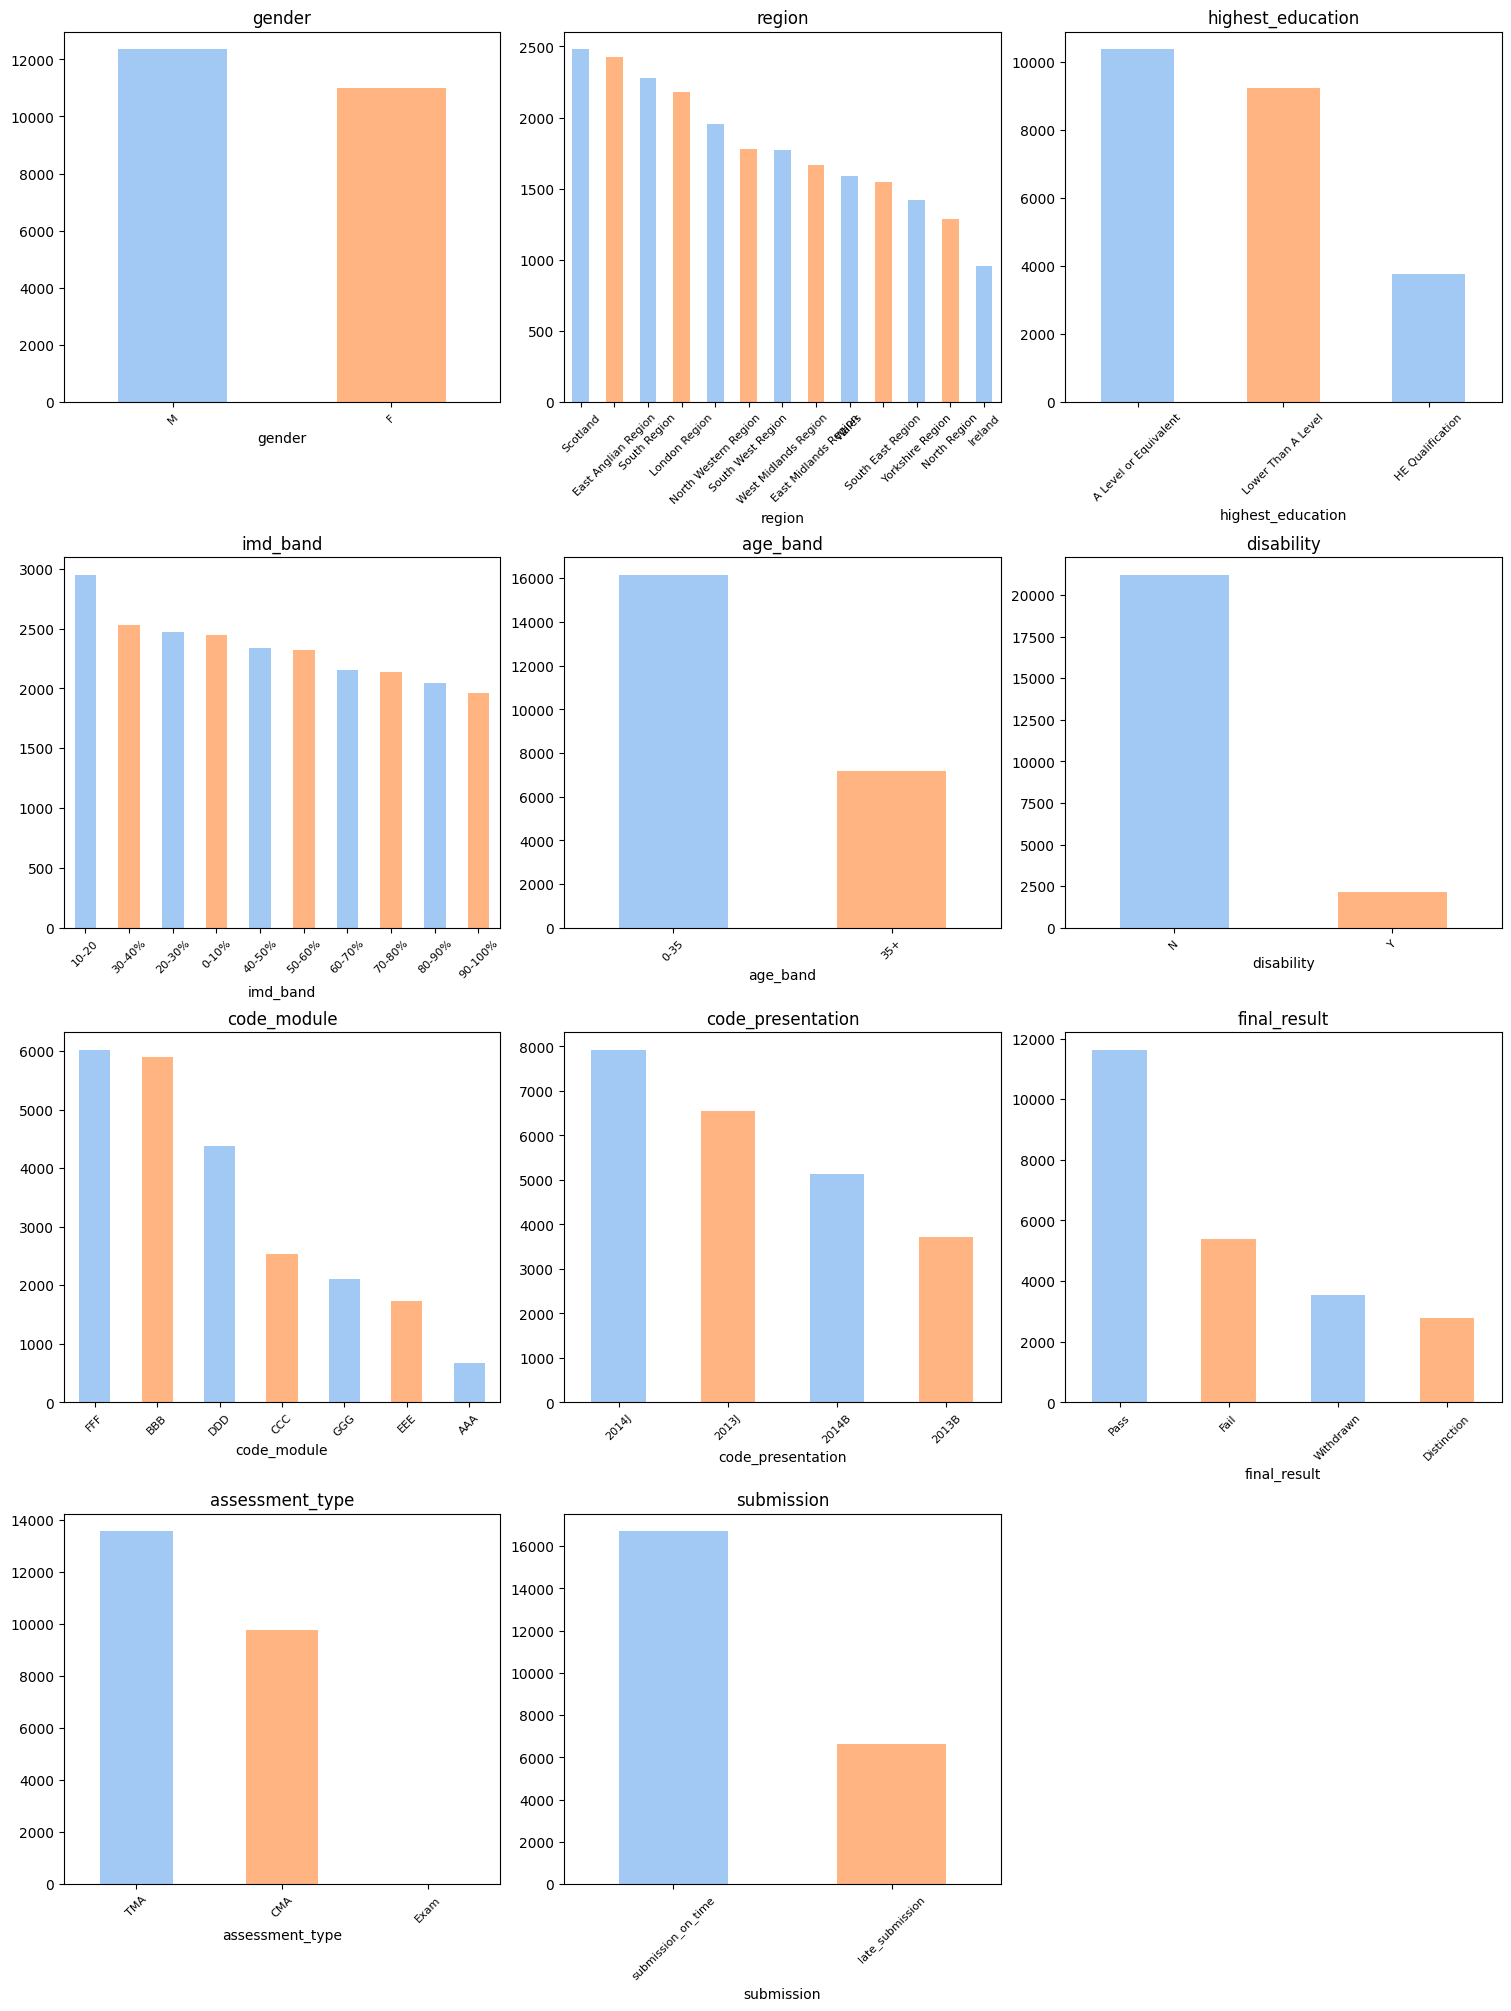

In [212]:
num_cols = 3  # Number of columns in the grid
num_rows = (len(cat_columns.columns) + num_cols - 1) // num_cols

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True)
axes = axes.flatten()
palette = sns.color_palette("pastel", len(cat_columns.iloc[:, 0].value_counts()))

for i, col in enumerate(cat_columns.columns):
    cat_columns[col].value_counts().plot(kind='bar', ax=axes[i], color=palette)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)
for j in range(len(cat_columns.columns), len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [213]:
bands = data['imd_band'].unique()
bands

array(['90-100%', '20-30%', '50-60%', '80-90%', '30-40%', '70-80%',
       '10-20', '60-70%', '40-50%', '0-10%'], dtype=object)

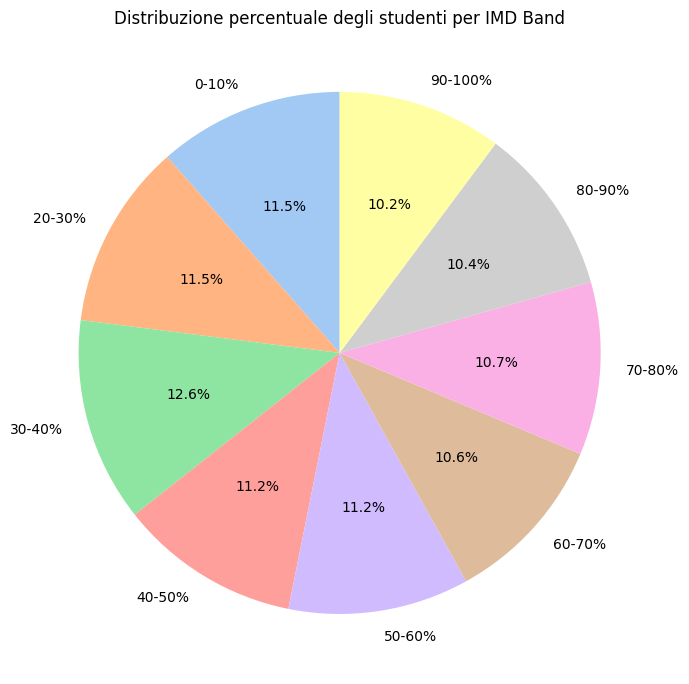

In [214]:
imd_percent = data['imd_band'].value_counts(normalize=True) * 100

# Ordina le categorie se vuoi (opzionale, utile per leggibilità)
ordered_bands = [
    '0-10%', '10-20%', '20-30%', '30-40%', '40-50%',
    '50-60%', '60-70%', '70-80%', '80-90%', '90-100%', 'Unknown'
]

imd_percent = imd_percent.reindex(ordered_bands).dropna()

# Trasforma in DataFrame (utile per plotting)
imd_percent_df = imd_percent.reset_index()
imd_percent_df.columns = ['imd_band', 'percent']

plt.figure(figsize=(7,7))
plt.pie(
    imd_percent_df['percent'],
    labels=imd_percent_df['imd_band'],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel')
)
plt.title("Distribuzione percentuale degli studenti per IMD Band")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [225]:
df['submission'].value_counts()

submission
submission_on_time    16693
late_submission        6651
Name: count, dtype: int64

In [222]:
df = df.drop('studied_credits_y', axis =1)

In [224]:
df.to_csv('df', index=False)